<a href="https://colab.research.google.com/github/jaimie-r/Predicting-Animal-Shelter-Outcomes-with-ML/blob/main/MLFinalProj_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Names: Jaimie Ren & Angela Walters

# Imports

In [ ]:
!pip install category_encoders

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import re
from collections import Counter
from scipy.special import softmax

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Preprocessing & encoding
from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders import TargetEncoder
from datetime import datetime

# Model selection and evaluation
from sklearn.model_selection import (
    cross_val_score, train_test_split, RandomizedSearchCV, StratifiedKFold
)
from sklearn.metrics import (
    classification_report, balanced_accuracy_score, confusion_matrix,
    make_scorer, accuracy_score, recall_score
)

# Sklearn models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, VotingClassifier, StackingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.decomposition import PCA
from sklearn.utils import resample

# Boosting models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Neural networks (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# For inline plotting in notebooks
%matplotlib inline

# Data Exploration & Cleaning


Make sure train.csv & test.csv in directory! Path can be replaced as well.

In [ ]:
# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Quick look at the data
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print(train.head())
print(train.info())
print(test.info())
print(test.head())

Train shape: (111157, 14)
Test shape: (27791, 11)
        Id          Name             Intake Time  \
0  A706918         Belle  07/05/2015 12:59:00 PM   
1  A724273       Runster  04/14/2016 06:43:00 PM   
2  A857105  Johnny Ringo  05/12/2022 12:23:00 AM   
3  A743852          Odin  02/18/2017 12:46:00 PM   
4  A635072       Beowulf  04/16/2019 09:53:00 AM   

                        Found Location      Intake Type Intake Condition  \
0     9409 Bluegrass Dr in Austin (TX)            Stray           Normal   
1   2818 Palomino Trail in Austin (TX)            Stray           Normal   
2   4404 Sarasota Drive in Austin (TX)    Public Assist           Normal   
3                          Austin (TX)  Owner Surrender           Normal   
4  415 East Mary Street in Austin (TX)    Public Assist           Normal   

  Animal Type Sex upon Intake Age upon Intake                     Breed  \
0         Dog   Spayed Female         8 years  English Springer Spaniel   
1         Dog     Intact Male 

In [ ]:
# explore missing values
missing_values = train.isnull().sum()
print("\nMissing values in train set:\n", missing_values)


Missing values in train set:
 Id                      0
Name                31383
Intake Time             0
Found Location          0
Intake Type             0
Intake Condition        0
Animal Type             0
Sex upon Intake         2
Age upon Intake         1
Breed                   0
Color                   0
Outcome Time            0
Date of Birth           0
Outcome Type            0
dtype: int64


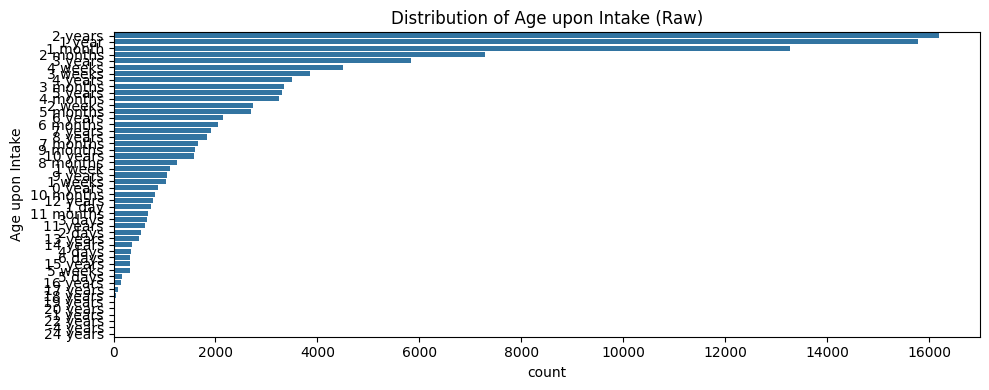

In [ ]:
# Visualize Age upon Intake (raw text) as a count of unique values
plt.figure(figsize=(10, 4))
sns.countplot(y='Age upon Intake', data=train, order=train['Age upon Intake'].value_counts().index)
plt.title("Distribution of Age upon Intake (Raw)")
plt.tight_layout()
plt.show()

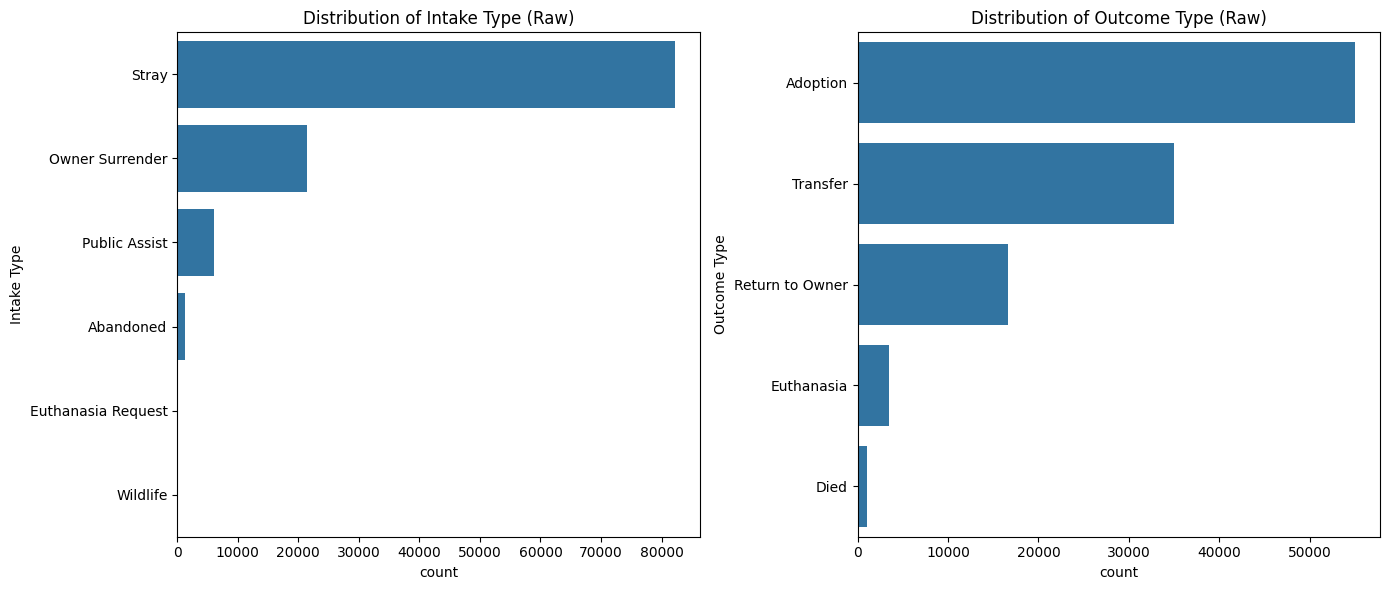

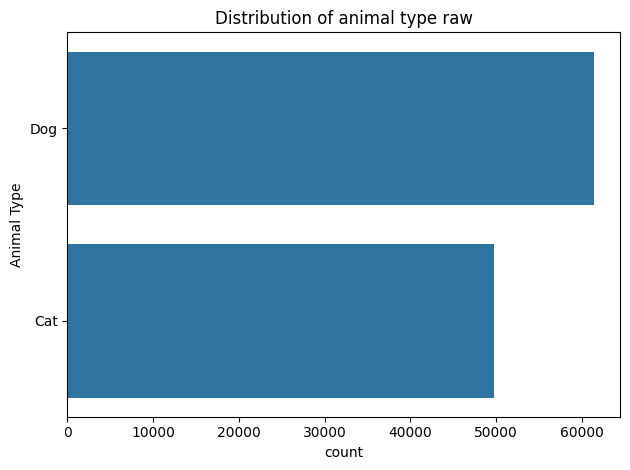

In [ ]:
# Visualize distributions for raw features
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(y='Intake Type', data=train, order=train['Intake Type'].value_counts().index)
plt.title("Distribution of Intake Type (Raw)")
plt.subplot(1, 2, 2)
sns.countplot(y='Outcome Type', data=train, order=train['Outcome Type'].value_counts().index)
plt.title("Distribution of Outcome Type (Raw)")
plt.tight_layout()
plt.show()

sns.countplot(y='Animal Type', data=train, order=train['Animal Type'].value_counts().index)
plt.title("Distribution of animal type raw")
plt.tight_layout()
plt.show()

In [ ]:
train_copy = train.copy()
test_copy = test.copy()

# handle missing values
cols_to_check = ['Sex upon Intake', 'Age upon Intake']
if all(col in train_copy.columns for col in cols_to_check):
    train_copy.dropna(subset=cols_to_check, inplace=True)

# make sure it's empty-less
missing_values = train_copy.isnull().sum()
print("\nMissing values in train set:\n", missing_values)


Missing values in train set:
 Id                      0
Name                31383
Intake Time             0
Found Location          0
Intake Type             0
Intake Condition        0
Animal Type             0
Sex upon Intake         0
Age upon Intake         0
Breed                   0
Color                   0
Outcome Time            0
Date of Birth           0
Outcome Type            0
dtype: int64


In [ ]:
print(train_copy.head(1))

        Id   Name             Intake Time                    Found Location  \
0  A706918  Belle  07/05/2015 12:59:00 PM  9409 Bluegrass Dr in Austin (TX)   

  Intake Type Intake Condition Animal Type Sex upon Intake Age upon Intake  \
0       Stray           Normal         Dog   Spayed Female         8 years   

                      Breed        Color            Outcome Time  \
0  English Springer Spaniel  White/Liver  07/05/2015 03:13:00 PM   

  Date of Birth     Outcome Type  
0    07/05/2007  Return to Owner  


Below is the majority of our cleaning -- mainly it's converting data into better formats, ex age into days since it was a string before, binary flag for had a name on file or not, etc. These are the more trivial cases, and further
below are the more complicated ones.

In [ ]:
# --- Date Conversion ---
# date formate was different for test & train sets so we have 2 format mappings
# Adjust date format mapping for both train and test data
date_format_mapping = {
    'Intake Time': "%m/%d/%Y %I:%M:%S %p",  # for train data
    'Outcome Time': "%m/%d/%Y %I:%M:%S %p",  # Handled gracefully if doesn't exist
    'Date of Birth': "%m/%d/%Y",
}

# Additional format for test data with potential short year and 24-hour time format
test_date_format_mapping = {
    'Intake Time': "%m/%d/%y %H:%M",  # for test data (2-digit year, 24-hour time)
}

# Convert dates in data
def convert_dates(df, date_mapping):
    for col, fmt in date_mapping.items():
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format=fmt, errors='coerce')
    return df

# Convert dates for train and test datasets with their respective formats
train_copy = convert_dates(train_copy, date_format_mapping)
test_copy = convert_dates(test_copy, test_date_format_mapping)

# Check for NaT (Not a Time) in test data
print("Test data after conversion:")
print(test_copy[['Intake Time']].head(10))

# --- Age Processing ---
def parse_age(age_str):
    if pd.isna(age_str) or not isinstance(age_str, str):
        return np.nan
    try:
        age, unit = age_str.split(' ')[:2]  # More robust splitting
        age = float(age)
        unit = unit.lower()
        if 'year' in unit:
            return age * 365
        elif 'month' in unit:
            return age * 30
        elif 'week' in unit:
            return age * 7
        elif 'day' in unit:
            return age
    except:
        pass
    return np.nan

if 'Age upon Intake' in train_copy.columns:
    train_copy['Age_in_days'] = train_copy['Age upon Intake'].apply(parse_age)
    train_copy.drop('Age upon Intake', axis=1, inplace=True, errors='ignore')

if 'Age upon Intake' in test_copy.columns:
    test_copy['Age_in_days'] = test_copy['Age upon Intake'].apply(parse_age)
    test_copy.drop('Age upon Intake', axis=1, inplace=True, errors='ignore')

Test data after conversion:
          Intake Time
0 2019-01-03 16:19:00
1 2013-10-21 07:59:00
2 2014-06-29 10:38:00
3 2015-07-11 18:19:00
4 2017-02-04 10:10:00
5 2022-03-30 09:27:00
6 2021-04-02 11:16:00
7 2023-02-21 15:26:00
8 2015-06-29 17:04:00
9 2015-05-05 07:29:00


In [ ]:
# --- Binary flag for Name ---
# using a binary flag indicating if an animal has a name or not and then dropping
if 'Name' in train_copy.columns:
    train_copy['Has_Name'] = train_copy['Name'].notnull().astype(int)
    train_copy.drop('Name', axis=1, inplace=True, errors='ignore')

if 'Name' in test_copy.columns:
    test_copy['Has_Name'] = test_copy['Name'].notnull().astype(int)
    test_copy.drop('Name', axis=1, inplace=True, errors='ignore')

In [ ]:
# --- Processing sex & fix status ---
def process_sex_alternative(sex_str):
    if pd.isna(sex_str):
        return np.nan, np.nan

    sex_str = str(sex_str).lower()

    is_male = 'male' in sex_str
    is_fixed = ('spayed' in sex_str) or ('neutered' in sex_str)

    return is_male, is_fixed

if 'Sex upon Intake' in train_copy.columns:
    train_copy[['Is_Male', 'Is_Fixed']] = train_copy['Sex upon Intake'].apply(
        lambda x: pd.Series(process_sex_alternative(x))
    )
    train_copy[['Is_Male', 'Is_Fixed']] = train_copy[['Is_Male', 'Is_Fixed']].astype(int)

if 'Sex upon Intake' in test_copy.columns:
    test_copy[['Is_Male', 'Is_Fixed']] = test_copy['Sex upon Intake'].apply(
        lambda x: pd.Series(process_sex_alternative(x))
    )
    test_copy[['Is_Male', 'Is_Fixed']] = test_copy[['Is_Male', 'Is_Fixed']].astype(int)

# --- Animal Type encoding --- (cat or dog changed to is_cat flag)
if 'Animal_Type' in train_copy.columns:
    train_copy['Is_Cat'] = (train_copy['Animal Type'] == 'Cat').astype(int)
    train_copy.drop('Animal_Type', axis=1, inplace=True, errors='ignore')

if 'Animal_Type' in test_copy.columns:
    test_copy['Is_Cat'] = (test_copy['Animal Type'] == 'Cat').astype(int)
    test_copy.drop('Animal_Type', axis=1, inplace=True, errors='ignore')

# --- Inspection ---
print("Train copy preview:")
display(train_copy.head(20))
print("\nTrain copy info:")
train_copy.info()

Train copy preview:


,Id,Intake Time,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color,Outcome Time,Date of Birth,Outcome Type,Age_in_days,Has_Name,Is_Male,Is_Fixed
0,A706918,2015-07-05 12:59:00,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,English Springer Spaniel,White/Liver,2015-07-05 15:13:00,2007-07-05,Return to Owner,2920.0,1,1,1
1,A724273,2016-04-14 18:43:00,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,Basenji Mix,Sable/White,2016-04-21 17:17:00,2015-04-17,Return to Owner,330.0,1,1,0
2,A857105,2022-05-12 00:23:00,4404 Sarasota Drive in Austin (TX),Public Assist,Normal,Cat,Neutered Male,Domestic Shorthair,Orange Tabby,2022-05-12 14:35:00,2020-05-12,Transfer,730.0,1,1,1
3,A743852,2017-02-18 12:46:00,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,Labrador Retriever Mix,Chocolate,2017-02-21 17:44:00,2015-02-18,Return to Owner,730.0,1,1,1
4,A635072,2019-04-16 09:53:00,415 East Mary Street in Austin (TX),Public Assist,Normal,Dog,Neutered Male,Great Dane Mix,Black,2019-04-18 13:45:00,2012-06-03,Return to Owner,2190.0,1,1,1
5,A844350,2021-10-15 11:40:00,2112 East William Cannon Drive in Austin (TX),Stray,Normal,Cat,Intact Female,Domestic Shorthair,Brown Tabby,2021-10-20 18:51:00,2021-04-15,Adoption,180.0,1,1,0
6,A708452,2015-07-30 14:37:00,Austin (TX),Public Assist,Normal,Dog,Intact Male,Labrador Retriever Mix,Black/White,2015-08-04 18:17:00,2013-07-28,Return to Owner,730.0,1,1,0
7,A818975,2020-06-18 14:53:00,Braker Lane And Metric in Travis (TX),Stray,Normal,Cat,Intact Male,Domestic Shorthair,Cream Tabby,2020-07-23 15:54:00,2020-05-19,Adoption,28.0,0,1,0
8,A774147,2018-06-11 07:45:00,6600 Elm Creek in Austin (TX),Stray,Injured,Cat,Intact Female,Domestic Shorthair Mix,Black/White,2018-06-11 00:00:00,2018-05-10,Transfer,28.0,0,1,0
9,A731435,2016-08-08 17:52:00,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,Domestic Shorthair Mix,Cream Tabby,2016-08-13 12:27:00,2016-02-22,Transfer,150.0,1,1,1



Train copy info:
<class 'pandas.core.frame.DataFrame'>
Index: 111155 entries, 0 to 111156
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Id                111155 non-null  object        
 1   Intake Time       111155 non-null  datetime64[ns]
 2   Found Location    111155 non-null  object        
 3   Intake Type       111155 non-null  object        
 4   Intake Condition  111155 non-null  object        
 5   Animal Type       111155 non-null  object        
 6   Sex upon Intake   111155 non-null  object        
 7   Breed             111155 non-null  object        
 8   Color             111155 non-null  object        
 9   Outcome Time      111155 non-null  datetime64[ns]
 10  Date of Birth     111155 non-null  datetime64[ns]
 11  Outcome Type      111155 non-null  object        
 12  Age_in_days       111155 non-null  float64       
 13  Has_Name          111155 non-null  int64      

In [ ]:
# --- Step 1: Clean the Found Location ---
def clean_address(addr):
    """
    Cleans the address data:
    - Removes ' in Austin (TX)'
    - Formats 'Austin (TX)' as 'Austin, TX'
    - Replaces 'Travis (TX)' with 'Travis County, TX'
    - Converts 'Outside Jurisdiction' and empty values to NaN
    """
    if pd.isnull(addr) or addr.strip().lower() == "outside jurisdiction":
        return np.nan  # Set to NaN for easier filtering

    # Replace "Travis (TX)" with "Travis County, TX"
    if "travis (tx)" in addr.lower():
        return "Travis County, TX"

    # Remove "in Austin (TX)" pattern
    cleaned = re.sub(r'\s+in\s+Austin\s*\(TX\)', '', addr, flags=re.IGNORECASE).strip()

    # If the cleaned address is exactly "Austin (TX)", replace it properly
    if cleaned.lower() == "austin (tx)":
        return "Austin, TX"

    # If Austin is not already in the cleaned address, append it
    if "austin" not in cleaned.lower():
        cleaned = f"{cleaned}, Austin, TX"

    return cleaned

# Apply cleaning to the Found Location column
if 'Found Location' in train_copy.columns:
  train_copy['Cleaned_Address'] = train_copy['Found Location'].apply(clean_address)
  train_copy.drop('Found Location', axis=1, inplace=True)

if 'Found Location' in test_copy.columns:
  test_copy['Cleaned_Address'] = test_copy['Found Location'].apply(clean_address)
  test_copy.drop('Found Location', axis=1, inplace=True)

train_copy.head(20)

,Id,Intake Time,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Color,Outcome Time,Date of Birth,Outcome Type,Age_in_days,Has_Name,Is_Male,Is_Fixed,Cleaned_Address
0,A706918,2015-07-05 12:59:00,Stray,Normal,Dog,Spayed Female,English Springer Spaniel,White/Liver,2015-07-05 15:13:00,2007-07-05,Return to Owner,2920.0,1,1,1,"9409 Bluegrass Dr, Austin, TX"
1,A724273,2016-04-14 18:43:00,Stray,Normal,Dog,Intact Male,Basenji Mix,Sable/White,2016-04-21 17:17:00,2015-04-17,Return to Owner,330.0,1,1,0,"2818 Palomino Trail, Austin, TX"
2,A857105,2022-05-12 00:23:00,Public Assist,Normal,Cat,Neutered Male,Domestic Shorthair,Orange Tabby,2022-05-12 14:35:00,2020-05-12,Transfer,730.0,1,1,1,"4404 Sarasota Drive, Austin, TX"
3,A743852,2017-02-18 12:46:00,Owner Surrender,Normal,Dog,Neutered Male,Labrador Retriever Mix,Chocolate,2017-02-21 17:44:00,2015-02-18,Return to Owner,730.0,1,1,1,"Austin, TX"
4,A635072,2019-04-16 09:53:00,Public Assist,Normal,Dog,Neutered Male,Great Dane Mix,Black,2019-04-18 13:45:00,2012-06-03,Return to Owner,2190.0,1,1,1,"415 East Mary Street, Austin, TX"
5,A844350,2021-10-15 11:40:00,Stray,Normal,Cat,Intact Female,Domestic Shorthair,Brown Tabby,2021-10-20 18:51:00,2021-04-15,Adoption,180.0,1,1,0,"2112 East William Cannon Drive, Austin, TX"
6,A708452,2015-07-30 14:37:00,Public Assist,Normal,Dog,Intact Male,Labrador Retriever Mix,Black/White,2015-08-04 18:17:00,2013-07-28,Return to Owner,730.0,1,1,0,"Austin, TX"
7,A818975,2020-06-18 14:53:00,Stray,Normal,Cat,Intact Male,Domestic Shorthair,Cream Tabby,2020-07-23 15:54:00,2020-05-19,Adoption,28.0,0,1,0,"Travis County, TX"
8,A774147,2018-06-11 07:45:00,Stray,Injured,Cat,Intact Female,Domestic Shorthair Mix,Black/White,2018-06-11 00:00:00,2018-05-10,Transfer,28.0,0,1,0,"6600 Elm Creek, Austin, TX"
9,A731435,2016-08-08 17:52:00,Owner Surrender,Normal,Cat,Neutered Male,Domestic Shorthair Mix,Cream Tabby,2016-08-13 12:27:00,2016-02-22,Transfer,150.0,1,1,1,"Austin, TX"


In [ ]:
# breed processing
def process_breeds_v2(breed_series, min_count=50):
    """Enhanced breed processing that better handles mixed breeds"""
    breed_counts = breed_series.value_counts()
    breed_map = {}

    # List of special breeds we want to preserve
    special_breeds = [
        'pit bull', 'labrador retriever', 'chihuahua',
        'german shepherd', 'australian cattle dog',
        'siamese', 'dachshund', 'border collie',
        'boxer', 'poodle', 'siberian husky',
        'great dane', 'bernese mountain', 'shiba inu',
        'havanese', 'akita', 'bullmastiff', 'dalmatian'
    ]

    for breed, count in breed_counts.items():
        breed_lower = str(breed).lower()

        # Handle domestic cats first
        if 'domestic' in breed_lower:
            hair_type = ''
            if 'shorthair' in breed_lower: hair_type = 'Shorthair'
            elif 'medium' in breed_lower: hair_type = 'Mediumhair'
            elif 'longhair' in breed_lower: hair_type = 'Longhair'
            breed_map[breed] = f'Domestic {hair_type}' if hair_type else 'Domestic Cat'
            continue

        # Handle mixed breeds with special logic
        if '/' in breed_lower or 'mix' in breed_lower:
            parts = breed_lower.replace(' mix', '').split('/')

            # Check if any part is a special breed
            special_parts = [p for p in parts if any(sb in p for sb in special_breeds)]

            if special_parts:
                # Take the first special breed found
                main_breed = special_parts[0]
                breed_map[breed] = main_breed.title() + (' Mix' if 'mix' in breed_lower else ' Mix')
            else:
                # No special breeds found in mix
                if count >= min_count:
                    breed_map[breed] = breed.title()
                else:
                    breed_map[breed] = 'Other Mixed Breed'
            continue

        # Handle non-mixed breeds
        if any(sb in breed_lower for sb in special_breeds):
            breed_map[breed] = breed.title()
        else:
            if count >= min_count:
                breed_map[breed] = breed.title()
            else:
                # Group by animal type
                if 'cat' in breed_lower or 'feline' in breed_lower:
                    breed_map[breed] = 'Other Cat Breed'
                else:
                    breed_map[breed] = 'Other Dog Breed'

    return breed_series.map(breed_map)

# Apply the new processing
train_copy['Breed_Processed_v2'] = process_breeds_v2(train_copy['Breed'])
test_copy['Breed_Processed_v2'] = process_breeds_v2(test_copy['Breed'])

# Show results
print("\nImproved Breed Distribution:")
breed_dist_v2 = train_copy['Breed_Processed_v2'].value_counts()
print(breed_dist_v2.head(20))
print("\nRare breeds after processing:")
print(breed_dist_v2[breed_dist_v2 < 5])


Improved Breed Distribution:
Breed_Processed_v2
Domestic Shorthair           41444
Labrador Retriever Mix        7997
Pit Bull Mix                  6843
Chihuahua Shorthair Mix       6146
Domestic Mediumhair           4005
German Shepherd Mix           3595
Other Mixed Breed             3382
Pit Bull                      2117
Australian Cattle Dog Mix     1881
Domestic Longhair             1809
Dachshund Mix                 1413
Chihuahua Shorthair           1390
Labrador Retriever            1341
Other Dog Breed               1338
Border Collie Mix             1164
German Shepherd               1125
Siamese Mix                   1112
Miniature Poodle Mix          1083
Boxer Mix                     1065
Siberian Husky Mix             815
Name: count, dtype: int64

Rare breeds after processing:
Breed_Processed_v2
Dachshund Stan Mix    1
Name: count, dtype: int64


In [ ]:
# color analysis
color_dist = train_copy['Color'].value_counts()
print("Top 20 Colors:")
print(color_dist.head(20))

print("\nTotal unique colors:", len(color_dist))
print("Colors with <10 occurrences:", len(color_dist[color_dist < 10]))

Top 20 Colors:
Color
Black/White          11620
Black                 9674
Brown Tabby           7708
White                 3945
Brown Tabby/White     3862
Orange Tabby          3673
Brown/White           3457
Tan/White             3178
White/Black           3045
Blue/White            3003
Tan                   2740
Brown                 2619
Black/Tan             2382
Black/Brown           2336
Tortie                2310
Tricolor              2294
Blue                  2218
Calico                2170
Blue Tabby            2024
White/Brown           2018
Name: count, dtype: int64

Total unique colors: 568
Colors with <10 occurrences: 365


In [ ]:
# Unique raw colors
print(train_copy['Color'].nunique())

# Top 20 raw color combos
print(train_copy['Color'].value_counts().head(20))

# Split and analyze primary colors
from collections import Counter

all_colors = train_copy['Color'].dropna().str.split('/')
flat_colors = [c.strip() for sublist in all_colors for c in sublist]
color_freq = Counter(flat_colors)

print("\nTop 20 primary colors:")
for color, count in color_freq.most_common(20):
    print(f"{color}: {count}")
# COLOR ENCODING

def process_colors_v2(color_series, rare_threshold=100):
    """Splits color into primary/secondary, detects multicolor and patterns, and groups rare colors."""
    from collections import Counter

    # Step 1: Gather all individual colors
    split_colors = color_series.dropna().str.split('/')
    flat_colors = [c.strip().lower() for sublist in split_colors for c in sublist]
    color_counts = Counter(flat_colors)

    # Define known pattern indicators
    patterns = ['tabby', 'tortie', 'torbie', 'brindle', 'tricolor', 'calico']

    def parse_color(raw_color):
        if pd.isna(raw_color):
            return pd.Series({
                'Color1': 'Unknown',
                'Color2': 'None',
                'Is_Multicolor': 0,
                'Has_Pattern': 0
            })

        parts = [p.strip().lower() for p in raw_color.split('/')]

        # Primary and secondary color
        color1 = parts[0] if parts else 'unknown'
        color2 = parts[1] if len(parts) > 1 else 'none'

        # Group rare base colors
        color1 = color1 if color_counts[color1] >= rare_threshold else 'other'
        color2 = color2 if color2 != 'none' and color_counts[color2] >= rare_threshold else 'none'

        # Title case for consistency
        color1 = color1.title()
        color2 = color2.title()

        # Pattern check
        has_pattern = int(any(p in raw_color.lower() for p in patterns))

        return pd.Series({
            'Color1': color1,
            'Color2': color2,
            'Is_Multicolor': int(color2 != 'None'),
            'Has_Pattern': has_pattern
        })

    return color_series.apply(parse_color)

568
Color
Black/White          11620
Black                 9674
Brown Tabby           7708
White                 3945
Brown Tabby/White     3862
Orange Tabby          3673
Brown/White           3457
Tan/White             3178
White/Black           3045
Blue/White            3003
Tan                   2740
Brown                 2619
Black/Tan             2382
Black/Brown           2336
Tortie                2310
Tricolor              2294
Blue                  2218
Calico                2170
Blue Tabby            2024
White/Brown           2018
Name: count, dtype: int64

Top 20 primary colors:
White: 49760
Black: 34067
Brown: 13454
Tan: 12504
Brown Tabby: 12264
Blue: 5962
Orange Tabby: 5713
Tricolor: 3412
Brown Brindle: 3330
Blue Tabby: 3040
Red: 2844
Tortie: 2502
Calico: 2405
Torbie: 1846
Gray: 1789
Chocolate: 1593
Cream: 1426
Cream Tabby: 1424
Sable: 813
Fawn: 790


In [ ]:
# more time encoding stuff
def add_time_features(df):
    # Parse intake time (we still need this for time-based features)
    df['Intake Time'] = pd.to_datetime(df['Intake Time'], errors='coerce')

    # Age bucket from existing Age_in_days
    def age_bucket(days):
        if pd.isna(days):
            return 'Unknown'
        elif days < 180:
            return 'Baby'
        elif days < 730:
            return 'Young'
        elif days < 2555:
            return 'Adult'
        else:
            return 'Senior'

    df['Age_Bucket'] = df['Age_in_days'].apply(age_bucket)

    # Time-based features from intake time
    df['Intake_Hour'] = df['Intake Time'].dt.hour
    df['Intake_Weekday'] = df['Intake Time'].dt.weekday
    df['Is_Intake_Weekend'] = df['Intake_Weekday'].isin([5, 6]).astype(int)
    df['Is_Intake_Evening'] = (df['Intake_Hour'] >= 17).astype(int)

    # Holiday season flag
    def is_holiday(ts):
        if pd.isna(ts):
            return 0
        return int((ts.month == 12 and ts.day >= 15) or (ts.month == 1 and ts.day <= 1))

    df['Is_Holiday_Season'] = df['Intake Time'].apply(is_holiday)

    # Drop intake time (and any remaining non-useful columns if needed)
    df.drop(columns=['Date of Birth'], inplace=True)

    return df

In [ ]:
def calculate_shelter_capacity(df):
    # Parse intake and outtake times
    df['Intake Time'] = pd.to_datetime(df['Intake Time'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    df['Outcome Time'] = pd.to_datetime(df['Outcome Time'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

    # Create a DataFrame to track the number of animals in the shelter each day
    date_range = pd.date_range(start=df['Intake Time'].min(), end=df['Outcome Time'].max())
    capacity_df = pd.DataFrame(date_range, columns=['Date'])
    capacity_df['Capacity'] = 0

    # Iterate over each row in the original DataFrame
    for index, row in df.iterrows():
        intake_time = row['Intake Time']
        outtake_time = row['Outcome Time']

        # Increment capacity for each day the animal is in the shelter
        if pd.notna(intake_time) and pd.notna(outtake_time):
            capacity_df.loc[(capacity_df['Date'] >= intake_time) & (capacity_df['Date'] <= outtake_time), 'Capacity'] += 1

    return capacity_df

capacity_df = calculate_shelter_capacity(train_copy)

In [ ]:
max_capacity = capacity_df['Capacity'].max()
capacity_df.loc[capacity_df['Date'] < '2020-01-01', 'Capacity'] /= max_capacity
capacity_df.loc[capacity_df['Date'] >= '2020-01-01', 'Capacity'] /= 1000
train_copy = pd.merge_asof(train_copy.sort_values('Intake Time'), capacity_df, left_on='Intake Time', right_on='Date', direction='backward')
train_copy.drop('Date', axis=1, inplace=True)
test_copy = pd.merge_asof(test_copy.sort_values('Intake Time'), capacity_df, left_on='Intake Time', right_on='Date', direction='backward')
test_copy.drop('Date', axis=1, inplace=True)

<ipython-input-19-25b43efb4928>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00070721 0.03323904 0.04879774 ... 0.60183876 0.5990099  0.59405941]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  capacity_df.loc[capacity_df['Date'] < '2020-01-01', 'Capacity'] /= max_capacity


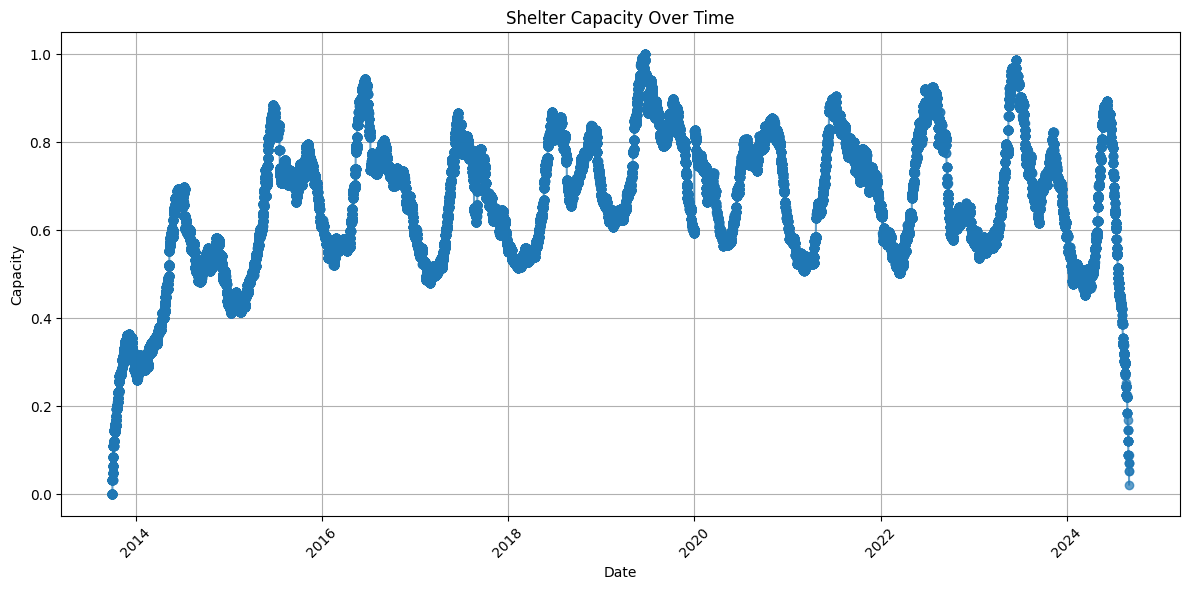

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_copy['Intake Time'], train_copy['Capacity'], marker='o', linestyle='-', alpha=0.7)
plt.title('Shelter Capacity Over Time')
plt.xlabel('Date')
plt.ylabel('Capacity')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Decision Trees Flag engineering

In [ ]:
DT_train_copy = train_copy.copy()
DT_test_copy = test_copy.copy()

if 'Color' in DT_train_copy.columns:
    train_color_features = process_colors_v2(DT_train_copy['Color'])
    DT_train_copy = pd.concat([DT_train_copy, train_color_features], axis=1)
    DT_train_copy.drop('Color', axis=1, inplace=True)

if 'Color' in DT_test_copy.columns:
    train_color_features = process_colors_v2(DT_test_copy['Color'])
    DT_test_copy = pd.concat([DT_test_copy, train_color_features], axis=1)
    DT_test_copy.drop('Color', axis=1, inplace=True)

#drop duplicate age column oopsies
if 'Age_from_DOB' in DT_train_copy.columns:
    DT_train_copy.drop('Age_from_DOB', axis=1, inplace=True)
if 'Age_from_DOB' in DT_test_copy.columns:
    DT_test_copy.drop('Age_from_DOB', axis=1, inplace=True)
# intake time exists here

In [ ]:
# can't run twice becuase this method drops intake time
DT_train_copy = add_time_features(DT_train_copy)
DT_test_copy = add_time_features(DT_test_copy)

In [ ]:
# Define custom flags for better modeling
def add_custom_flags(df):
    # --- Flag: common breeds
    common_breeds = [
        'Domestic Shorthair', 'Labrador Retriever Mix', 'Pit Bull Mix',
        'Chihuahua Shorthair Mix', 'German Shepherd Mix'
    ]
    df['Is_Common_Breed'] = df['Breed_Processed_v2'].isin(common_breeds).astype(int)

    # --- Flag: mixed vs purebred (from original 'Breed' column)
    def is_mixed(breed):
        if pd.isna(breed):
            return 0
        return int('Mix' in breed or '/' in breed)

    df['Is_Mixed_Breed'] = df['Breed'].apply(is_mixed)

    # --- Flag: likely transfer candidate
    df['Is_Likely_Transfer'] = (
        (
            (df['Animal Type'] == 'Cat') &
            (df['Breed_Processed_v2'] == 'Domestic Shorthair') &
            (df['Age_Bucket'].isin(['Baby', 'Young'])) &
            (df['Intake Condition'] == 'Normal')
        ) |
        (
            (df['Animal Type'] == 'Dog') &
            (df['Breed_Processed_v2'].isin([
                'Pit Bull Mix', 'Labrador Retriever Mix', 'German Shepherd Mix'
            ])) &
            (df['Age_Bucket'].isin(['Young', 'Adult'])) &
            (df['Intake Type'].isin(['Stray', 'Public Assist']))
        )
    ).astype(int)


    # --- Flag: shelter high-capacity seasons
    def is_capacity_season(row):
        # Assuming intake time already extracted into hour/weekday
        if pd.isna(row['Intake_Hour']) or pd.isna(row['Intake_Weekday']):
            return 0
        # Define this as mid-summer (June-Aug) or post-holiday January
        return int(row['Intake_Weekday'] in [0,1,2] and row['Intake_Hour'] >= 10)

    df['Is_High_Capacity_Season'] = df.apply(is_capacity_season, axis=1)

    # added after analyzing misclassified adoptions
    df['Is_Transfer_Like_Male'] = (
        (df['Is_Male'] == 1) &
        (df['Is_Fixed'] == 0) &
        (df['Age_Bucket'] == 'Young') &
        (df['Intake Type'] == 'Stray')
    ).astype(int)

    df['SexFixAgeIntake'] = (
        df['Is_Male'].astype(str) + '_' +
        df['Is_Fixed'].astype(str) + '_' +
        df['Age_Bucket'].astype(str) + '_' +
        df['Intake Type'].astype(str)
    )

    df['Is_Transfer_Profiled'] = (
      (df['Is_Male'] == 1) &
      (df['Is_Fixed'] == 0) &
      (df['Age_Bucket'].isin(['Baby', 'Young']))&
      (df['Intake Type'].isin(['Stray', 'Public Assist']))
    ).astype(int)

    df['Is_Sick'] = (
        (df['Intake Condition'].isin(['Injured', 'Sick', 'Medical', 'Med Attn']))
    ).astype(int)

    return df

# Apply to both datasets (after breeds and time features are ready)
DT_train_copy = add_custom_flags(DT_train_copy)
DT_test_copy = add_custom_flags(DT_test_copy)


In [ ]:
DT_train_copy.head()

,Id,Intake Time,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed,Outcome Time,Outcome Type,Age_in_days,...,Is_Intake_Evening,Is_Holiday_Season,Is_Common_Breed,Is_Mixed_Breed,Is_Likely_Transfer,Is_High_Capacity_Season,Is_Transfer_Like_Male,SexFixAgeIntake,Is_Transfer_Profiled,Is_Sick
0,A521520,2013-10-01 07:51:00,Stray,Normal,Dog,Spayed Female,Border Terrier/Border Collie,2013-10-01 15:39:00,Return to Owner,2555.0,...,0,0,0,1,0,0,0,1_1_Senior_Stray,0,0
1,A664235,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,Domestic Shorthair Mix,2013-10-01 10:39:00,Transfer,7.0,...,0,0,1,1,1,0,0,0_0_Baby_Stray,0,0
2,A664237,2013-10-01 08:33:00,Stray,Normal,Cat,Unknown,Domestic Shorthair Mix,2013-10-01 10:44:00,Transfer,7.0,...,0,0,1,1,1,0,0,0_0_Baby_Stray,0,0
3,A664238,2013-10-01 09:33:00,Stray,Normal,Cat,Unknown,American Shorthair Mix,2013-10-01 16:47:00,Euthanasia,120.0,...,0,0,0,1,0,0,0,0_0_Baby_Stray,0,0
4,A664234,2013-10-01 10:37:00,Stray,Injured,Dog,Intact Male,Border Collie Mix,2013-10-01 19:09:00,Euthanasia,2920.0,...,0,0,0,1,0,1,0,1_0_Senior_Stray,0,1


In [ ]:
# location features (flags)
def add_simple_location_features(df):
    # Normalize nulls
    addresses = df['Cleaned_Address'].fillna("").str.lower().str.strip()

    has_street_number = []
    has_full_address = []

    for addr in addresses:
        tokens = addr.split()

        # Check if address starts with a number
        has_number = tokens[0].isdigit() if tokens else False
        has_street_number.append(int(has_number))

        # Check if it's not just "austin, tx" or "travis county, tx"
        basic_austin = ("austin, tx" in addr and len(tokens) <= 3)
        basic_travis = ("travis county, tx" in addr and len(tokens) <= 4)
        full_addr = not (basic_austin or basic_travis)
        has_full_address.append(int(full_addr))

    df['Has_Street_Number'] = has_street_number
    df['Has_Full_Address'] = has_full_address

    return df

In [ ]:
DT_train_copy = add_simple_location_features(DT_train_copy)
DT_test_copy = add_simple_location_features(DT_test_copy)

with pd.option_context('display.max_columns', None):
    print(DT_train_copy.head(1))
with pd.option_context('display.max_columns', None):
    print(DT_test_copy.head(1))

        Id         Intake Time Intake Type Intake Condition Animal Type  \
0  A521520 2013-10-01 07:51:00       Stray           Normal         Dog   

  Sex upon Intake                         Breed        Outcome Time  \
0   Spayed Female  Border Terrier/Border Collie 2013-10-01 15:39:00   

      Outcome Type  Age_in_days  Has_Name  Is_Male  Is_Fixed  \
0  Return to Owner       2555.0         1        1         1   

        Cleaned_Address Breed_Processed_v2  Capacity Color1 Color2  \
0  Norht Ec, Austin, TX  Border Collie Mix  0.000707  White    Tan   

   Is_Multicolor  Has_Pattern Age_Bucket  Intake_Hour  Intake_Weekday  \
0              1            0     Senior            7               1   

   Is_Intake_Weekend  Is_Intake_Evening  Is_Holiday_Season  Is_Common_Breed  \
0                  0                  0                  0                0   

   Is_Mixed_Breed  Is_Likely_Transfer  Is_High_Capacity_Season  \
0               1                   0                        0  

# Decision Tree

OG Decision tree, first thing we tried

In [ ]:
# Step 1: Apply feature engineering
train_processed = DT_train_copy.copy()
test_processed = DT_test_copy.copy()

# Step 2: Select columns to use
feature_cols = [ 'Intake Type', 'Intake Condition', 'Animal Type', 'Sex upon Intake', 'Breed_Processed_v2',
                 'Color1', 'Color2', 'Is_Male', 'Is_Fixed', 'Is_Multicolor',
                 'Has_Pattern', 'Age_in_days', 'Age_Bucket', 'Intake_Hour', 'Intake_Weekday',
                 'Has_Street_Number', 'Has_Full_Address', 'Is_Likely_Transfer',
                 'Is_High_Capacity_Season', 'Is_Mixed_Breed', 'Is_Common_Breed',
                 'Is_Transfer_Like_Male', 'Is_Holiday_Season', 'Is_Intake_Evening', 'Is_Intake_Weekend',
                 'SexFixAgeIntake', 'Is_Transfer_Profiled', 'Is_Sick', 'Capacity']
# Define X and X_test
X = train_processed[feature_cols]
y = train_processed['Outcome Type']  # Target
X_test = test_processed[feature_cols]

# Step 3: Encode all categorical columns
cat_cols = X.select_dtypes(include='object').columns
encoders = {}

# Encoding categorical columns in X
for col in cat_cols:
    le = LabelEncoder()
    X.loc[:, col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le  # Store the encoder for later use in X_test

# Encoding categorical columns in X_test with the same encoders
for col in cat_cols:
    le = encoders[col]
    test_vals = X_test[col].astype(str)

    # Map unseen values to 'Unknown'
    known_classes = set(le.classes_)
    if 'Unknown' not in known_classes:
        le.classes_ = np.append(le.classes_, 'Unknown')

    test_vals = test_vals.where(test_vals.isin(known_classes), 'Unknown')
    X_test.loc[:, col] = le.transform(test_vals)

# Encode the target column 'Outcome Type' if it has categorical string values
if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)

# Step 4: Train + Evaluate with Cross-Validation
model = DecisionTreeClassifier(random_state=42, max_depth=10)

scores = cross_val_score(model, X, y, cv=5, scoring='balanced_accuracy')
print(f"\nCross-validated Balanced Accuracy (5 folds): {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Baseline validation
X_train_split, X_val_split, y_train_split, y_val_baseline = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train_split, y_train_split)
y_pred = model.predict(X_val_split)

print("\nValidation Classification Report:")
print(classification_report(y_val_baseline, y_pred))

balanced_acc = balanced_accuracy_score(y_val_baseline, y_pred)
print(f"Balanced Accuracy on Validation Set: {balanced_acc:.4f}")


Cross-validated Balanced Accuracy (5 folds): 0.3681 ± 0.0172

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.84      0.72     11050
           1       0.25      0.03      0.06       213
           2       0.47      0.19      0.27       695
           3       0.60      0.54      0.56      3348
           4       0.66      0.41      0.51      6925

    accuracy                           0.63     22231
   macro avg       0.52      0.40      0.42     22231
weighted avg       0.63      0.63      0.61     22231

Balanced Accuracy on Validation Set: 0.4015


# Regular DT

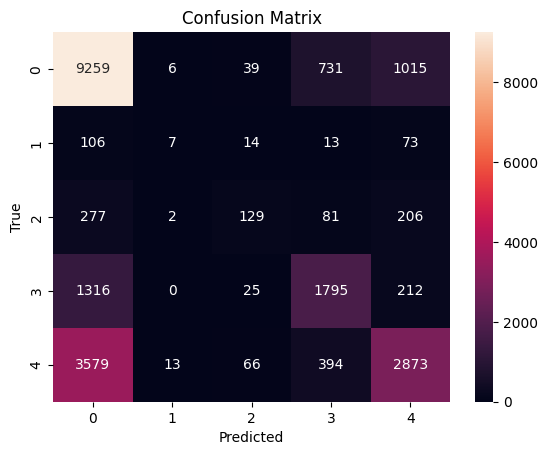

In [ ]:
cm = confusion_matrix(y_val_baseline, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Decision Tree with class_weight='balanced'
from sklearn.tree import DecisionTreeClassifier

model_balanced = DecisionTreeClassifier(random_state=42, max_depth=10, class_weight='balanced')

scores_bal = cross_val_score(model_balanced, X, y, cv=5, scoring='balanced_accuracy')
print(f"\n[DT w/ Balanced Class Weights] Cross-Val Balanced Accuracy: {np.mean(scores_bal):.4f} ± {np.std(scores_bal):.4f}")

X_train_split, X_val_split, y_train_split, y_val_weighted = train_test_split(X, y, test_size=0.2, random_state=42)
model_balanced.fit(X_train_split, y_train_split)
y_pred_bal = model_balanced.predict(X_val_split)

print("\nClassification Report (Balanced DT):")
print(classification_report(y_val_weighted, y_pred_bal))

bal_acc_bal = balanced_accuracy_score(y_val_weighted, y_pred_bal)
print(f"Balanced Accuracy (Balanced DT): {bal_acc_bal:.4f}")



[DT w/ Balanced Class Weights] Cross-Val Balanced Accuracy: 0.4264 ± 0.0334

Classification Report (Balanced DT):
              precision    recall  f1-score   support

           0       0.73      0.48      0.58     11050
           1       0.03      0.39      0.06       213
           2       0.16      0.43      0.24       695
           3       0.39      0.77      0.52      3348
           4       0.63      0.35      0.45      6925

    accuracy                           0.48     22231
   macro avg       0.39      0.49      0.37     22231
weighted avg       0.62      0.48      0.51     22231

Balanced Accuracy (Balanced DT): 0.4852


Trying upsampling instead of the balanced flag

In [ ]:
# Combine X and y for easier resampling
df_combined = X.copy()
df_combined['Outcome Type'] = y

# Identify majority class
majority_class = df_combined['Outcome Type'].value_counts().idxmax()
n_major = df_combined['Outcome Type'].value_counts().max()

# Upsample all minority classes
resampled_parts = []
for cls in df_combined['Outcome Type'].unique():
    group = df_combined[df_combined['Outcome Type'] == cls]
    if len(group) < n_major:
        group = resample(group, replace=True, n_samples=n_major, random_state=42)
    resampled_parts.append(group)

df_upsampled = pd.concat(resampled_parts)
X_up = df_upsampled.drop(columns='Outcome Type')
y_up = df_upsampled['Outcome Type']

In [ ]:
# Train DT on upsampled data
model_upsampled = DecisionTreeClassifier(random_state=42, max_depth=10)
scores_up = cross_val_score(model_upsampled, X_up, y_up, cv=5, scoring='balanced_accuracy')
print(f"\n[Upsampled DT] Cross-Val Balanced Accuracy: {np.mean(scores_up):.4f} ± {np.std(scores_up):.4f}")

X_train_split, X_val_split, y_train_split, y_val_upsampled = train_test_split(X_up, y_up, test_size=0.2, random_state=42)
model_upsampled.fit(X_train_split, y_train_split)
y_pred_up = model_upsampled.predict(X_val_split)

print("\nClassification Report (Upsampled DT):")
print(classification_report(y_val_upsampled, y_pred_up))

bal_acc_up = balanced_accuracy_score(y_val_upsampled, y_pred_up)
print(f"Balanced Accuracy (Upsampled DT): {bal_acc_up:.4f}")


[Upsampled DT] Cross-Val Balanced Accuracy: 0.5664 ± 0.0137

Classification Report (Upsampled DT):
              precision    recall  f1-score   support

           0       0.50      0.47      0.48     10976
           1       0.62      0.73      0.67     11130
           2       0.66      0.60      0.63     11045
           3       0.57      0.77      0.66     10985
           4       0.57      0.34      0.43     10908

    accuracy                           0.58     55044
   macro avg       0.58      0.58      0.57     55044
weighted avg       0.58      0.58      0.57     55044

Balanced Accuracy (Upsampled DT): 0.5840



[Random Forest] Cross-Val Balanced Accuracy: 0.7383 ± 0.0150

Classification Report (Random Forest on Upsampled):
              precision    recall  f1-score   support

           0       0.59      0.60      0.60     10976
           1       0.95      1.00      0.97     11130
           2       0.81      0.89      0.85     11045
           3       0.68      0.82      0.74     10985
           4       0.74      0.46      0.57     10908

    accuracy                           0.75     55044
   macro avg       0.75      0.75      0.75     55044
weighted avg       0.75      0.75      0.75     55044

Balanced Accuracy (Random Forest on Upsampled): 0.7536


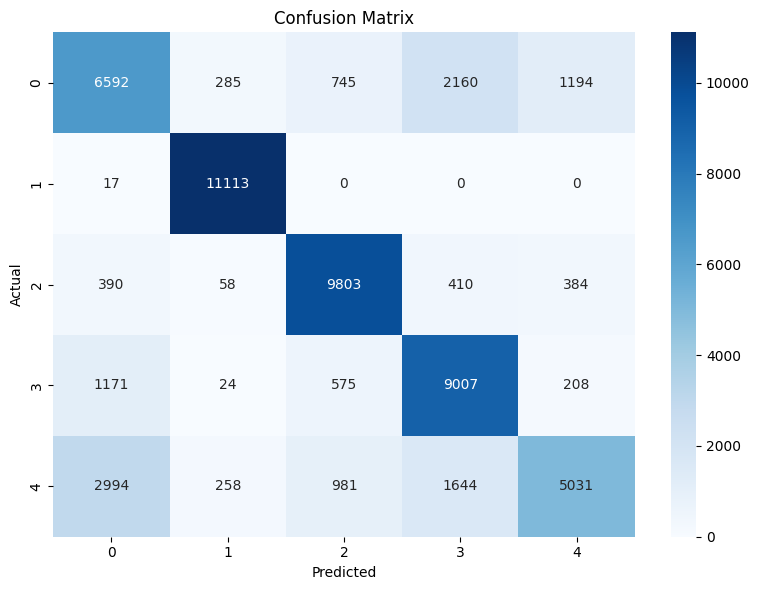


🔍 Sample Misclassified Records:


,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed_Processed_v2,Color1,Color2,Is_Male,Is_Fixed,Is_Multicolor,...,Is_Transfer_Like_Male,Is_Holiday_Season,Is_Intake_Evening,Is_Intake_Weekend,SexFixAgeIntake,Is_Transfer_Profiled,Is_Sick,Capacity,Actual,Predicted
37058,4,11,1,1,5,41,26,1,0,0,...,1,0,0,0,35,1,0,0.726308,0,3
79681,4,5,0,2,70,13,39,1,1,1,...,0,0,0,1,50,0,1,0.766000,4,2
69436,2,11,1,2,103,29,0,1,1,1,...,0,0,0,1,48,0,0,0.942008,0,3
104341,4,11,1,0,84,41,26,1,0,0,...,0,0,0,0,20,0,0,0.715000,0,3
57676,4,5,1,0,92,17,26,1,0,0,...,0,0,0,1,25,1,1,0.843706,0,1
45012,4,16,0,1,71,0,26,1,0,0,...,0,0,0,1,25,1,1,0.865629,0,2
76904,4,11,1,2,48,6,39,1,1,1,...,0,0,0,1,40,0,0,0.674000,4,3
23510,4,11,1,0,113,11,39,1,0,1,...,0,0,0,1,25,1,0,0.758840,4,0
90162,4,5,0,1,72,27,39,1,0,1,...,0,0,0,0,25,1,1,0.589000,4,2
16006,4,5,0,2,72,27,26,1,1,0,...,0,0,0,1,40,0,1,0.449788,0,2


In [ ]:
# using upsampling**
# RF config
rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=20,
    n_estimators=420,
    min_samples_split=50,
    min_samples_leaf=10,
    class_weight='balanced',
    n_jobs=-1
)

# Cross-val scores
rf_scores = cross_val_score(rf_model, X_up, y_up, cv=5, scoring='balanced_accuracy')
print(f"\n[Random Forest] Cross-Val Balanced Accuracy: {np.mean(rf_scores):.4f} ± {np.std(rf_scores):.4f}")

# Train/val split and fit
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_up, y_up, test_size=0.2, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_val_rf)

# Classification report
print("\nClassification Report (Random Forest on Upsampled):")
print(classification_report(y_val_rf, y_pred_rf))

# Balanced accuracy
rf_bal_acc = balanced_accuracy_score(y_val_rf, y_pred_rf)
print(f"Balanced Accuracy (Random Forest on Upsampled): {rf_bal_acc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(y_val_rf, y_pred_rf, labels=rf_model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Sample Misclassified Records ---
misclassified_mask = y_val_rf != y_pred_rf
misclassified_samples = X_val_rf[misclassified_mask].copy()
misclassified_samples['Actual'] = y_val_rf[misclassified_mask].values
misclassified_samples['Predicted'] = y_pred_rf[misclassified_mask]

print("\nSample Misclassified Records:")
display(misclassified_samples.sample(10))


🌲 [RF - Original Data] Cross-Val Balanced Accuracy: 0.4740 ± 0.0039

📄 Classification Report (RF on Original Data):
              precision    recall  f1-score   support

           0       0.72      0.60      0.66     11050
           1       0.07      0.21      0.10       213
           2       0.20      0.59      0.30       695
           3       0.43      0.76      0.55      3348
           4       0.64      0.40      0.49      6925

    accuracy                           0.56     22231
   macro avg       0.41      0.51      0.42     22231
weighted avg       0.63      0.56      0.57     22231

🎯 Balanced Accuracy (RF on Original Data): 0.5123


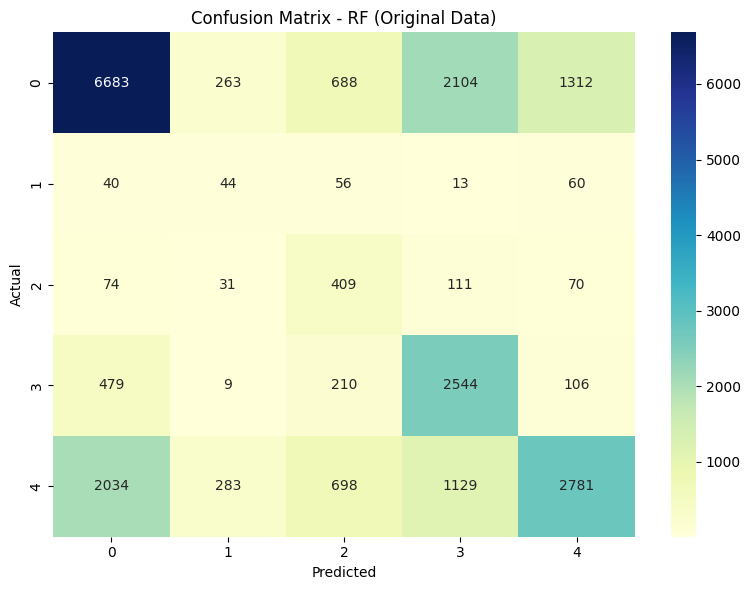


🔍 Sample Misclassified Records (Original Data RF):


,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed_Processed_v2,Color1,Color2,Is_Male,Is_Fixed,Is_Multicolor,...,Is_Transfer_Like_Male,Is_Holiday_Season,Is_Intake_Evening,Is_Intake_Weekend,SexFixAgeIntake,Is_Transfer_Profiled,Is_Sick,Capacity,Actual,Predicted
4337,4,11,1,3,138,32,26,1,1,0,...,0,0,0,0,40,0,0,0.324611,0,3
21973,2,11,1,2,38,11,39,1,1,1,...,0,0,0,0,54,0,0,0.867044,2,0
27456,4,11,1,1,93,17,26,1,0,0,...,1,0,0,1,35,1,0,0.737624,4,0
108157,4,11,1,3,112,11,39,1,1,1,...,0,0,0,0,40,0,0,0.523000,0,3
67220,3,11,1,1,51,36,26,1,0,0,...,0,0,0,0,19,0,0,0.935644,4,3
80322,4,11,1,1,59,10,26,1,0,0,...,0,0,0,1,20,0,0,0.812000,4,3
53063,4,0,0,2,72,13,39,1,1,1,...,0,0,0,0,50,0,0,0.528289,3,2
34145,4,11,1,2,113,36,26,1,1,0,...,0,0,0,0,40,0,0,0.870580,0,3
35269,4,5,0,3,70,13,26,1,1,0,...,0,0,0,1,56,0,1,0.757426,4,2
80209,4,11,1,0,6,0,39,1,0,1,...,0,0,0,0,20,0,0,0.789000,4,3


In [ ]:
# Random Forest configuration (same as before), just not upsampled
rf_model_base = RandomForestClassifier(
    random_state=42,
    max_depth=20,
    n_estimators=420,
    min_samples_split=50,
    min_samples_leaf=10,
    class_weight='balanced',
    n_jobs=-1
)

# Cross-validation on original (non-upsampled) data
rf_scores_base = cross_val_score(rf_model_base, X, y, cv=5, scoring='balanced_accuracy')
print(f"\n [RF - Original Data] Cross-Val Balanced Accuracy: {np.mean(rf_scores_base):.4f} ± {np.std(rf_scores_base):.4f}")

# Train/val split and fit
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_base.fit(X_train_base, y_train_base)
y_pred_base = rf_model_base.predict(X_val_base)

# Classification report
print("\nClassification Report (RF on Original Data):")
print(classification_report(y_val_base, y_pred_base))

# Balanced accuracy
rf_bal_acc_base = balanced_accuracy_score(y_val_base, y_pred_base)
print(f"Balanced Accuracy (RF on Original Data): {rf_bal_acc_base:.4f}")

# Confusion Matrix
cm_base = confusion_matrix(y_val_base, y_pred_base, labels=rf_model_base.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_base, annot=True, fmt='d',
            xticklabels=rf_model_base.classes_,
            yticklabels=rf_model_base.classes_,
            cmap='YlGnBu')
plt.title("Confusion Matrix - RF (Original Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Sample Misclassifications
misclassified_base_mask = y_val_base != y_pred_base
misclassified_base = X_val_base[misclassified_base_mask].copy()
misclassified_base['Actual'] = y_val_base[misclassified_base_mask]
misclassified_base['Predicted'] = y_pred_base[misclassified_base_mask]

print("\n🔍 Sample Misclassified Records (Original Data RF):")
display(misclassified_base.sample(10))

In [ ]:
importances = rf_model_base.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train_base.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

display(feature_importance_df.head(25))

,Feature,Importance
11,Age_in_days,0.141886
28,Capacity,0.099811
27,Is_Sick,0.089229
25,SexFixAgeIntake,0.071773
13,Intake_Hour,0.055327
1,Intake Condition,0.054372
0,Intake Type,0.051606
4,Breed_Processed_v2,0.051386
2,Animal Type,0.050839
5,Color1,0.046356


In [ ]:
# Decode using the correct LabelEncoder used for y (le_target)
misclassified_mask = y_val_rf != y_pred_rf
misclassified_samples = X_val_rf[misclassified_mask].copy()
misclassified_samples['Actual'] = y_val_rf[misclassified_mask]
misclassified_samples['Predicted'] = y_pred_rf[misclassified_mask]

# Decode actual and predicted using the original target encoder
misclassified_samples['Actual'] = le_target.inverse_transform(misclassified_samples['Actual'])
misclassified_samples['Predicted'] = le_target.inverse_transform(misclassified_samples['Predicted'])

# Show the most common misclassification pairs
print("Misclassification Summary (Actual vs Predicted):")
confusion_pairs = (
    misclassified_samples.groupby(['Actual', 'Predicted'])
    .size()
    .reset_index(name='Count')
    .sort_values('Count', ascending=False)
)
display(confusion_pairs)

# Inspect a specific type of error
target_actual = 'Transfer'
target_pred = 'Adoption'

subset = misclassified_samples[
    (misclassified_samples['Actual'] == target_actual) &
    (misclassified_samples['Predicted'] == target_pred)
]

print(f"\nMisclassified as '{target_pred}' instead of '{target_actual}': ({len(subset)} records)")
if len(subset) > 0:
    display(subset.sample(min(10, len(subset))))
else:
    print("No records found for that combination.")


🔢 Misclassification Summary (Actual vs Predicted):


,Actual,Predicted,Count
13,Transfer,Adoption,2994
2,Adoption,Return to Owner,2160
16,Transfer,Return to Owner,1644
3,Adoption,Transfer,1194
9,Return to Owner,Adoption,1171
15,Transfer,Euthanasia,981
1,Adoption,Euthanasia,745
11,Return to Owner,Euthanasia,575
7,Euthanasia,Return to Owner,410
5,Euthanasia,Adoption,390



🔍 Misclassified as 'Adoption' instead of 'Transfer': (2994 records)


,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Breed_Processed_v2,Color1,Color2,Is_Male,Is_Fixed,Is_Multicolor,...,Is_Transfer_Like_Male,Is_Holiday_Season,Is_Intake_Evening,Is_Intake_Weekend,SexFixAgeIntake,Is_Transfer_Profiled,Is_Sick,Capacity,Actual,Predicted
48869,4,11,0,0,72,13,26,1,0,0,...,0,0,0,0,25,1,0,0.686704,Transfer,Adoption
74646,4,11,1,1,78,0,35,1,0,1,...,1,0,0,1,35,1,0,0.799859,Transfer,Adoption
73829,4,11,0,1,72,23,26,1,0,0,...,0,0,0,0,25,1,0,0.837341,Transfer,Adoption
94004,4,11,1,1,52,17,26,1,0,0,...,1,0,0,0,35,1,0,0.879000,Transfer,Adoption
57792,4,11,1,0,113,11,39,1,0,1,...,1,0,0,0,35,1,0,0.813296,Transfer,Adoption
28814,2,11,0,1,72,18,26,1,0,0,...,0,0,0,0,33,0,0,0.570014,Transfer,Adoption
5497,4,11,1,0,14,10,29,1,0,1,...,0,0,0,0,25,1,0,0.366337,Transfer,Adoption
50605,4,11,1,1,17,36,39,1,0,1,...,0,0,0,0,25,1,0,0.646393,Transfer,Adoption
80577,4,11,0,1,72,0,26,1,0,0,...,0,0,0,0,25,1,0,0.829000,Transfer,Adoption
57944,2,11,1,2,104,41,0,1,1,1,...,0,0,0,0,48,0,0,0.786421,Transfer,Adoption


In [ ]:
# Filter misclassified Transfer → Adoption cases
transfer_to_adopt = misclassified_samples[
    (misclassified_samples['Actual'] == 'Transfer') &
    (misclassified_samples['Predicted'] == 'Adoption')
]

print(f"🔍 Total Transfer → Adoption misclassifications: {len(transfer_to_adopt)}")

# 1. Gender/Fix status distribution
print("\nSex & Fix Status:")
print(transfer_to_adopt[['Is_Male', 'Is_Fixed']].value_counts().rename_axis(['Is_Male', 'Is_Fixed']).reset_index(name='Count'))

# 2. Breakdown of % male / % fixed
total = len(transfer_to_adopt)
percent_male = transfer_to_adopt['Is_Male'].mean()
percent_fixed = transfer_to_adopt['Is_Fixed'].mean()
percent_cat = transfer_to_adopt['Animal Type'].mean()

print(f"\nPercent Male: {percent_male:.2%}")
print(f"Percent Fixed: {percent_fixed:.2%}")
print(f"Percent Cats: {percent_cat:.2%}")

# 3. Optional: breakdown by age bucket or intake type
print("\nAge Bucket:")
print(transfer_to_adopt['Age_Bucket'].value_counts())

print("\nIntake Type:")
print(transfer_to_adopt['Intake Type'].value_counts())


🔍 Total Transfer → Adoption misclassifications: 2994

🧑‍⚖️ Sex & Fix Status:
   Is_Male  Is_Fixed  Count
0        1         0   2501
1        1         1    493

➡️ Percent Male: 100.00%
➡️ Percent Fixed: 16.47%
Percent Cats: 59.92%

📊 Age Bucket:
Age_Bucket
1    1716
3     792
0     379
2     107
Name: count, dtype: int64

🚪 Intake Type:
Intake Type
4    1866
2    1089
0      33
3       4
1       2
Name: count, dtype: int64


In [ ]:
# Feature importance lookup
importances = rf_model.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': X_up.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n📊 Feature Importance for Random Forest:")
display(feat_importance.head(25))


📊 Feature Importance for Random Forest:


,Feature,Importance
11,Age_in_days,0.136790
28,Capacity,0.110454
27,Is_Sick,0.078102
25,SexFixAgeIntake,0.065347
13,Intake_Hour,0.065314
5,Color1,0.051973
1,Intake Condition,0.051585
4,Breed_Processed_v2,0.051120
0,Intake Type,0.048348
2,Animal Type,0.044440



📊 Balanced Accuracy Comparison:
                                  Model  Balanced Accuracy
              Decision Tree (Upsampled)           0.583966
Decision Tree (class_weight='balanced')           0.485188
               Decision Tree (Baseline)           0.401482
              precision    recall  f1-score   support

           0       0.50      0.47      0.48     10976
           1       0.62      0.73      0.67     11130
           2       0.66      0.60      0.63     11045
           3       0.57      0.77      0.66     10985
           4       0.57      0.34      0.43     10908

    accuracy                           0.58     55044
   macro avg       0.58      0.58      0.57     55044
weighted avg       0.58      0.58      0.57     55044



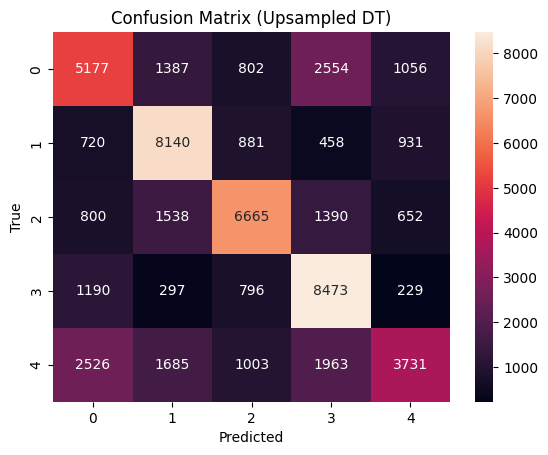


📊 Balanced Accuracy Comparison (Updated):
                                  Model  Balanced Accuracy
              Random Forest (Upsampled)           0.753553
              Decision Tree (Upsampled)           0.583966
Decision Tree (class_weight='balanced')           0.485188
               Decision Tree (Baseline)           0.401482


In [ ]:
summary = {
    "Model": [
        "Decision Tree (Baseline)",
        "Decision Tree (class_weight='balanced')",
        "Decision Tree (Upsampled)"
    ],
    "Balanced Accuracy": [
        balanced_accuracy_score(y_val_baseline, y_pred),
        balanced_accuracy_score(y_val_weighted, y_pred_bal),
        balanced_accuracy_score(y_val_upsampled, y_pred_up)
    ]
}

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values(by="Balanced Accuracy", ascending=False)

print("\nBalanced Accuracy Comparison:")
print(summary_df.to_string(index=False))

from sklearn.metrics import classification_report
print(classification_report(y_val_upsampled, y_pred_up))


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val_upsampled, y_pred_up, labels=model_upsampled.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model_upsampled.classes_, yticklabels=model_upsampled.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Upsampled DT)')
plt.show()

# Add to summary
summary["Model"].append("Random Forest (Upsampled)")
summary["Balanced Accuracy"].append(rf_bal_acc)
summary_df = pd.DataFrame(summary).sort_values(by="Balanced Accuracy", ascending=False)

print("\nBalanced Accuracy Comparison (Updated):")
print(summary_df.to_string(index=False))


In [ ]:
# 1. Fit on data
rf_model.fit(X, y)

# 2. Predict on test set
rf_preds_up = rf_model.predict(X_test)

# 3. Convert predictions back to labels
final_preds_up = le_target.inverse_transform(rf_preds_up)
'''
# 4. Save Kaggle submission
submission_up = pd.DataFrame({
    'Id': test_copy['Id'],
    'Outcome': final_preds_up
})
submission_up.to_csv('submission_rf_upsampled.csv', index=False)
print("Submission with upsampled RF saved as 'submission_rf_upsampled.csv'")'''

🚀 Submission with upsampled RF saved as 'submission_rf_upsampled.csv'


In [ ]:
# Re-align X_test to match rf_model_base's training features
X_test_base = X_test.reindex(columns=rf_model_base.feature_names_in_, fill_value=0)

# === 1. Get predicted probabilities from both models ===
probs_up = rf_model.predict_proba(X_test)
probs_base = rf_model_base.predict_proba(X_test_base)

# === 2. Average the probabilities ===
ensemble_probs = (probs_up + probs_base) / 2

# === 3. Set class name and threshold for special treatment ===
target_class = 'Adoption'
threshold = 0.55  # You can try 0.60 or 0.65 too

# Get class index for Adoption
le_outcome = LabelEncoder()
le_outcome.fit(train_processed['Outcome Type'])  # Fit on original string labels

target_idx = le_outcome.transform(['Adoption'])[0]

# === 4. Apply custom threshold logic ===
custom_preds = []
for prob in ensemble_probs:
    if prob[target_idx] >= threshold:
        custom_preds.append(target_idx)
    else:
        # Pick highest non-Adoption class
        non_target_idx = np.argmax([p if i != target_idx else -1 for i, p in enumerate(prob)])
        custom_preds.append(non_target_idx)
'''
# === 5. Convert predictions to original labels ===
final_preds = le_outcome.inverse_transform(custom_preds)

# === 6. Save to submission CSV ===
submission_df = pd.DataFrame({
    'Id': test_copy['Id'],
    'Outcome Type': final_preds
})

submission_df.to_csv('submission_ensemble_thresh.csv', index=False)
print("Submission file saved as 'submission_ensemble_thresh.csv'")'''

✅ Submission file saved as 'submission_ensemble_thresh.csv'


In [ ]:
# this was for testing hyperparams, commented out since it takes a while to run
'''# Define hyperparameter grid
param_grid = [
    {"max_depth": 20, "min_samples_split": 50, "min_samples_leaf": 10},
    {"max_depth": 25, "min_samples_split": 30, "min_samples_leaf": 5},
    {"max_depth": 30, "min_samples_split": 20, "min_samples_leaf": 2},
    {"max_depth": 35, "min_samples_split": 10, "min_samples_leaf": 1},
]

results = []

datasets = [("Original", X, y), ("Upsampled", X_up, y_up)]

for dataset_name, X_data, y_data in datasets:
    for params in param_grid:
        model = RandomForestClassifier(
            n_estimators=500,
            max_depth=params["max_depth"],
            min_samples_split=params["min_samples_split"],
            min_samples_leaf=params["min_samples_leaf"],
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )

        # Cross-val
        scores = cross_val_score(model, X_data, y_data, cv=5, scoring='balanced_accuracy')
        avg_score = np.mean(scores)

        # Train/val split for confusion matrix
        X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        cm = confusion_matrix(y_val, y_pred)

        results.append({
            "Dataset": dataset_name,
            "max_depth": params["max_depth"],
            "min_samples_split": params["min_samples_split"],
            "min_samples_leaf": params["min_samples_leaf"],
            "Balanced_Accuracy": avg_score,
            "Confusion_Matrix": cm
        })

# Results DataFrame
results_df = pd.DataFrame([{
    "Dataset": r["Dataset"],
    "max_depth": r["max_depth"],
    "min_samples_split": r["min_samples_split"],
    "min_samples_leaf": r["min_samples_leaf"],
    "Balanced_Accuracy": r["Balanced_Accuracy"]
} for r in results]).sort_values(by="Balanced_Accuracy", ascending=False)

display(results_df)
'''

'# Define hyperparameter grid\nparam_grid = [\n    {"max_depth": 20, "min_samples_split": 50, "min_samples_leaf": 10},\n    {"max_depth": 25, "min_samples_split": 30, "min_samples_leaf": 5},\n    {"max_depth": 30, "min_samples_split": 20, "min_samples_leaf": 2},\n    {"max_depth": 35, "min_samples_split": 10, "min_samples_leaf": 1},\n]\n\nresults = []\n\ndatasets = [("Original", X, y), ("Upsampled", X_up, y_up)]\n\nfor dataset_name, X_data, y_data in datasets:\n    for params in param_grid:\n        model = RandomForestClassifier(\n            n_estimators=500,\n            max_depth=params["max_depth"],\n            min_samples_split=params["min_samples_split"],\n            min_samples_leaf=params["min_samples_leaf"],\n            class_weight="balanced",\n            random_state=42,\n            n_jobs=-1\n        )\n\n        # Cross-val\n        scores = cross_val_score(model, X_data, y_data, cv=5, scoring=\'balanced_accuracy\')\n        avg_score = np.mean(scores)\n\n        # T


Internal Validation Balanced Accuracy: 0.5123


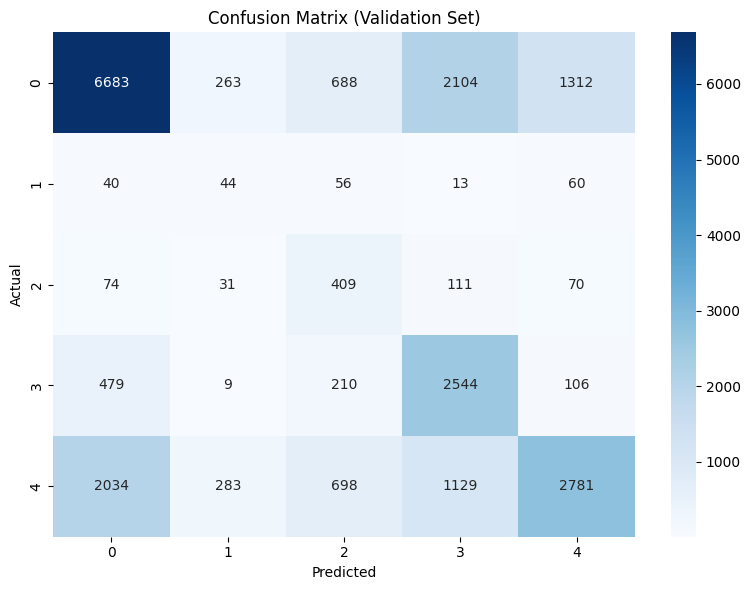

In [ ]:
# === Train best model on full original data ===
best_rf = RandomForestClassifier(
    n_estimators=420,
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=10,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

best_rf.fit(X, y)

# === Predict test set ===
rf_preds_best = best_rf.predict(X_test)
final_preds_best = le_target.inverse_transform(rf_preds_best)
'''
# === Save submission ===
submission_best = pd.DataFrame({
    'Id': test_copy['Id'],
    'Outcome': final_preds_best
})
submission_best.to_csv('submission_rf_final_best.csv', index=False)
print("Submission saved as 'submission_rf_final_best.csv'")
'''
# === Show confusion matrix on internal validation ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
best_rf.fit(X_train, y_train)
y_val_pred = best_rf.predict(X_val)
val_bal_acc = balanced_accuracy_score(y_val, y_val_pred)
print(f"\nInternal Validation Balanced Accuracy: {val_bal_acc:.4f}")

cm = confusion_matrix(y_val, y_val_pred, labels=best_rf.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
def breakdown_stats_v2(df, label):
    print(f"\n{label} — Total: {len(df)}")
    for col in ['Is_Male', 'Is_Fixed', 'Animal Type', 'Intake Type',
                'Age_Bucket', 'Has_Full_Address', 'Has_Street_Number', 'Is_High_Capacity_Season']:
        print(f"\n📊 Breakdown of {col}:")
        display(df[col].value_counts(dropna=False))

# --- Regenerate misclassified set ---
val_preds_df = X_val.copy()
val_preds_df['Actual'] = y_val
val_preds_df['Predicted'] = y_val_pred
val_preds_df['Misclassified'] = val_preds_df['Actual'] != val_preds_df['Predicted']
misclassified = val_preds_df[val_preds_df['Misclassified']].copy()

# --- 1. Adoption → Return to Owner ---
adopt_to_rto = misclassified[(misclassified['Actual'] == 0) & (misclassified['Predicted'] == 3)]
breakdown_stats_v2(adopt_to_rto, "Adoption → Return to Owner")

# --- 2. Transfer → Adoption ---
transfer_to_adopt = misclassified[(misclassified['Actual'] == 4) & (misclassified['Predicted'] == 0)]
breakdown_stats_v2(transfer_to_adopt, "Transfer → Adoption")

# --- 3. Adoption → Transfer ---
adopt_to_transfer = misclassified[(misclassified['Actual'] == 0) & (misclassified['Predicted'] == 4)]
breakdown_stats_v2(adopt_to_transfer, "Adoption → Transfer")


Adoption → Return to Owner — Total: 2104

📊 Breakdown of Is_Male:


,count
Is_Male,
1,2104



📊 Breakdown of Is_Fixed:


,count
Is_Fixed,
0,1311
1,793



📊 Breakdown of Animal Type:


,count
Animal Type,
1,1897
0,207



📊 Breakdown of Intake Type:


,count
Intake Type,
4,1925
3,172
0,7



📊 Breakdown of Age_Bucket:


,count
Age_Bucket,
0,1258
3,563
2,234
1,49



📊 Breakdown of Has_Full_Address:


,count
Has_Full_Address,
1,1763
0,341



📊 Breakdown of Has_Street_Number:


,count
Has_Street_Number,
1,1157
0,947



📊 Breakdown of Is_High_Capacity_Season:


,count
Is_High_Capacity_Season,
0,1235
1,869



Transfer → Adoption — Total: 2034

📊 Breakdown of Is_Male:


,count
Is_Male,
1,2034



📊 Breakdown of Is_Fixed:


,count
Is_Fixed,
0,1703
1,331



📊 Breakdown of Animal Type:


,count
Animal Type,
1,1210
0,824



📊 Breakdown of Intake Type:


,count
Intake Type,
4,1271
2,732
0,28
3,2
1,1



📊 Breakdown of Age_Bucket:


,count
Age_Bucket,
1,1178
3,510
0,267
2,79



📊 Breakdown of Has_Full_Address:


,count
Has_Full_Address,
1,1243
0,791



📊 Breakdown of Has_Street_Number:


,count
Has_Street_Number,
0,1161
1,873



📊 Breakdown of Is_High_Capacity_Season:


,count
Is_High_Capacity_Season,
0,1073
1,961



Adoption → Transfer — Total: 1312

📊 Breakdown of Is_Male:


,count
Is_Male,
1,1310
0,2



📊 Breakdown of Is_Fixed:


,count
Is_Fixed,
0,1306
1,6



📊 Breakdown of Animal Type:


,count
Animal Type,
0,1103
1,209



📊 Breakdown of Intake Type:


,count
Intake Type,
4,1151
2,125
3,26
0,10



📊 Breakdown of Age_Bucket:


,count
Age_Bucket,
1,747
3,285
0,266
2,14



📊 Breakdown of Has_Full_Address:


,count
Has_Full_Address,
1,1028
0,284



📊 Breakdown of Has_Street_Number:


,count
Has_Street_Number,
1,865
0,447



📊 Breakdown of Is_High_Capacity_Season:


,count
Is_High_Capacity_Season,
0,663
1,649


# DT Binary Classifier


In [ ]:
# Step 1: Create filtered dataset
train_binary_AR = DT_train_copy.copy()
test_binary_AR = DT_test_copy.copy()

feature_cols = [
    'Intake Type', 'Intake Condition', 'Animal Type', 'Breed_Processed_v2',
    'Color1', 'Color2', 'Is_Male', 'Is_Fixed', 'Is_Multicolor',
    'Has_Pattern', 'Age_in_days', 'Age_Bucket', 'Intake_Hour', 'Intake_Weekday',
    'Is_Intake_Weekend', 'Is_Intake_Evening', 'Is_Holiday_Season',
    'Has_Street_Number', 'Has_Full_Address', 'Is_Likely_Transfer',
    'Is_High_Capacity_Season', 'Is_Mixed_Breed', 'Is_Common_Breed',
    'Is_Transfer_Like_Male', 'SexFixAgeIntake'
]

# Filter to only Adoption vs Return to Owner
df_AR = train_binary_AR[train_binary_AR['Outcome Type'].isin(['Adoption', 'Return to Owner'])].copy()
df_AR['Adopt_vs_RTO'] = (df_AR['Outcome Type'] == 'Adoption').astype(int)

# Label encode categorical features
X_AR = df_AR[feature_cols].copy()
y_AR = df_AR['Adopt_vs_RTO']
encoders_AR = {}

cat_cols_AR = X_AR.select_dtypes(include='object').columns
for col in cat_cols_AR:
    le = LabelEncoder()
    X_AR[col] = le.fit_transform(X_AR[col].astype(str))
    encoders_AR[col] = le

# Step 2: Train binary classifier
rf_ar = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_ar.fit(X_AR, y_AR)

# Step 3: Apply to all records
def encode_and_predict(df):
    X_full = df[feature_cols].copy()
    for col in cat_cols_AR:
        le = encoders_AR[col]
        X_full[col] = X_full[col].astype(str)
        if 'Unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'Unknown')
        X_full[col] = X_full[col].where(X_full[col].isin(le.classes_), 'Unknown')
        X_full[col] = le.transform(X_full[col])
    return rf_ar.predict_proba(X_full)[:, 1]

# Add prediction columns
DT_train_copy['Adopt_vs_RTO'] = encode_and_predict(DT_train_copy)
DT_test_copy['Adopt_vs_RTO'] = encode_and_predict(DT_test_copy)

print("Done! Preview of new column:")
print(DT_train_copy[['Adopt_vs_RTO']].head())

Done! Preview of new column:
   Adopt_vs_RTO
0      0.106144
1      0.178665
2      0.178665
3      0.261688
4      0.282884


In [ ]:
# 1. Prepare the full dataset
feature_cols = [ 'Intake Type', 'Intake Condition', 'Animal Type', 'Breed_Processed_v2',
                 'Color1', 'Color2', 'Is_Male', 'Is_Fixed', 'Is_Multicolor',
                 'Has_Pattern', 'Age_in_days', 'Age_Bucket', 'Intake_Hour', 'Intake_Weekday',
                 'Is_Intake_Weekend', 'Is_Intake_Evening', 'Is_Holiday_Season',
                 'Has_Street_Number', 'Has_Full_Address', 'Is_Likely_Transfer',
                 'Is_High_Capacity_Season', 'Is_Mixed_Breed', 'Is_Common_Breed',
                 'Is_Transfer_Like_Male', 'SexFixAgeIntake']

full_data = DT_train_copy.copy()
test_data = DT_test_copy.copy()

X = full_data[feature_cols].copy()
y = full_data['Outcome Type']

X_test = test_data[feature_cols].copy()

# Label encode categorical columns
cat_cols = X.select_dtypes(include='object').columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    X_test[col] = X_test[col].astype(str).apply(lambda val: val if val in le.classes_ else 'Unknown')
    if 'Unknown' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'Unknown')
    X_test[col] = le.transform(X_test[col])
    encoders[col] = le

# Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# 2. Build the binary model (Adoption vs Transfer)
binary_mask = y.isin(['Adoption', 'Transfer'])
X_binary = X[binary_mask].copy()
y_binary = y[binary_mask].apply(lambda x: 1 if x == 'Adoption' else 0)

rf_binary = RandomForestClassifier(
    n_estimators=200, max_depth=12, random_state=42, class_weight='balanced', n_jobs=-1
)
rf_binary.fit(X_binary, y_binary)

# Add binary prediction as feature
DT_train_copy['Adopt_vs_Transfer'] = rf_binary.predict_proba(X)[:, 1]
DT_test_copy['Adopt_vs_Transfer'] = rf_binary.predict_proba(X_test)[:, 1]

print("Preview of new column:")
print(DT_train_copy[['Adopt_vs_Transfer']].head())

Preview of new column:
   Adopt_vs_Transfer
0           0.562491
1           0.000000
2           0.000000
3           0.014541
4           0.456240



Classification Report (Final RF w/ Binary Models):
                 precision    recall  f1-score   support

       Adoption       0.77      0.67      0.72     11050
           Died       0.08      0.20      0.11       213
     Euthanasia       0.22      0.57      0.32       695
Return to Owner       0.52      0.80      0.63      3348
       Transfer       0.68      0.50      0.58      6925

       accuracy                           0.63     22231
      macro avg       0.45      0.55      0.47     22231
   weighted avg       0.68      0.63      0.64     22231


Balanced Accuracy (Final RF): 0.5489


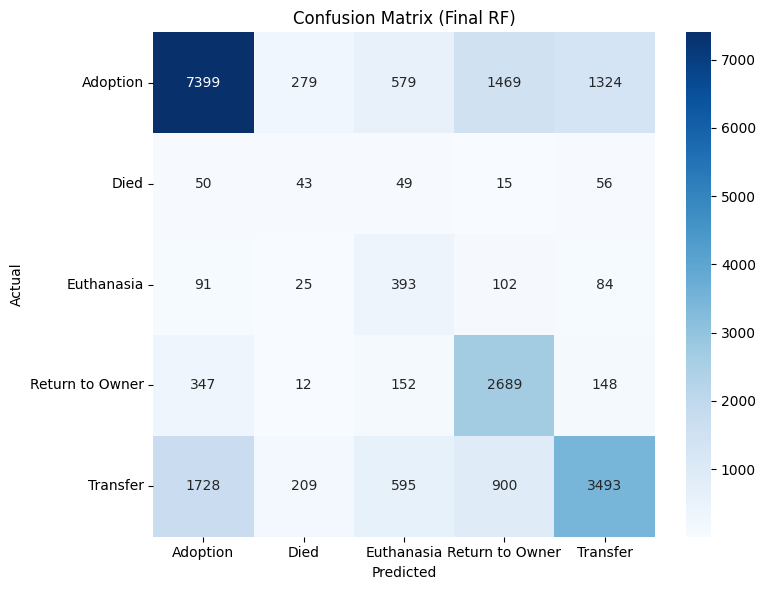


 Preview of binary model features added:


,Adopt_vs_Transfer,Adopt_vs_RTO
0,0.562491,0.106144
1,0.000000,0.178665
2,0.000000,0.178665
3,0.014541,0.261688
4,0.456240,0.282884


In [ ]:
# --- 1. Prepare the full dataset ---
feature_cols = [ 'Intake Type', 'Intake Condition', 'Animal Type', 'Breed_Processed_v2',
                 'Color1', 'Color2', 'Is_Male', 'Is_Fixed', 'Is_Multicolor',
                 'Has_Pattern', 'Age_in_days', 'Age_Bucket', 'Intake_Hour', 'Intake_Weekday',
                 'Is_Intake_Weekend', 'Is_Intake_Evening', 'Is_Holiday_Season',
                 'Has_Street_Number', 'Has_Full_Address', 'Is_Likely_Transfer',
                 'Is_High_Capacity_Season', 'Is_Mixed_Breed', 'Is_Common_Breed',
                 'Is_Transfer_Like_Male', 'SexFixAgeIntake',  # already present
                 'Adopt_vs_Transfer', 'Adopt_vs_RTO'          # new binary probs
               ]

full_data = DT_train_copy.copy()
test_data = DT_test_copy.copy()

X = full_data[feature_cols].copy()
y = full_data['Outcome Type']
X_test = test_data[feature_cols].copy()

# --- 2. Label encode categorical columns ---
cat_cols = X.select_dtypes(include='object').columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    X_test[col] = X_test[col].astype(str).apply(lambda val: val if val in le.classes_ else 'Unknown')
    if 'Unknown' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'Unknown')
    X_test[col] = le.transform(X_test[col])
    encoders[col] = le

# Encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# --- 3. Train/Test Split ---
X_train_stack, X_val_stack, y_train_stack, y_val_stack = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# --- 4. Final Random Forest ---
final_rf = RandomForestClassifier(
    random_state=42,
    n_estimators=420,
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=10,
    class_weight='balanced',
    n_jobs=-1
)

final_rf.fit(X_train_stack, y_train_stack)
y_pred_stack = final_rf.predict(X_val_stack)

# --- 5. Evaluation ---
print("\nClassification Report (Final RF w/ Binary Models):")
print(classification_report(y_val_stack, y_pred_stack, target_names=le_target.classes_))

stacked_acc = balanced_accuracy_score(y_val_stack, y_pred_stack)
print(f"\nBalanced Accuracy (Final RF): {stacked_acc:.4f}")

# --- 6. Confusion Matrix ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val_stack, y_pred_stack)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Final RF)")
plt.tight_layout()
plt.show()

# --- 7. Sanity check ---
print("\n Preview of binary model features added:")
display(X[['Adopt_vs_Transfer', 'Adopt_vs_RTO']].head())

In [ ]:
# --- Feature Importance ---
importances = final_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Final Random Forest):")
display(feature_importance_df)


Feature Importance (Final Random Forest):


,Feature,Importance
26,Adopt_vs_RTO,0.204814
25,Adopt_vs_Transfer,0.186028
10,Age_in_days,0.105746
1,Intake Condition,0.083677
24,SexFixAgeIntake,0.047717
12,Intake_Hour,0.046727
4,Color1,0.039546
3,Breed_Processed_v2,0.039038
13,Intake_Weekday,0.032595
2,Animal Type,0.030309


In [ ]:
'''# Train full model on all training data
final_rf.fit(X, y)

# Predict test set
test_preds = final_rf.predict(X_test)

# Ensure predictions are in integer form before decoding
if np.issubdtype(test_preds.dtype, np.integer):
    test_preds_labels = le_target.inverse_transform(test_preds)
else:
    test_preds_labels = test_preds  # already strings

# Now, create the submission DataFrame with the original string labels
submission = pd.DataFrame({
    'Id': test_copy['Id'],  # Assuming 'test_copy' contains the test data
    'Outcome': test_preds_labels  # Use the string labels here
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")
'''

'# Train full model on all training data\nfinal_rf.fit(X, y)\n\n# Predict test set\ntest_preds = final_rf.predict(X_test)\n\n# Ensure predictions are in integer form before decoding\nif np.issubdtype(test_preds.dtype, np.integer):\n    test_preds_labels = le_target.inverse_transform(test_preds)\nelse:\n    test_preds_labels = test_preds  # already strings\n\n# Now, create the submission DataFrame with the original string labels\nsubmission = pd.DataFrame({\n    \'Id\': test_copy[\'Id\'],  # Assuming \'test_copy\' contains the test data\n    \'Outcome\': test_preds_labels  # Use the string labels here\n})\n\n# Save to CSV\nsubmission.to_csv(\'submission.csv\', index=False)\nprint("Submission file saved as \'submission.csv\'")\n'

In [ ]:
'''# Predict test set using final model
test_preds_raw = final_rf.predict(X_test)

# Convert integer preds to label names
test_preds_labels = le_target.inverse_transform(test_preds_raw)

# Create DataFrame for adjustment
df_preds = test_copy.copy()
df_preds['Raw_Pred'] = test_preds_labels
df_preds['Adopt_vs_Transfer'] = X_test['Adopt_vs_Transfer']
df_preds['Adopt_vs_RTO'] = X_test['Adopt_vs_RTO']

# Apply rules:
# If model predicted Adoption but has low confidence for both binary classifiers → flip
mask_transfer = (df_preds['Raw_Pred'] == 'Adoption') & (df_preds['Adopt_vs_Transfer'] < 0.4)
mask_rto = (df_preds['Raw_Pred'] == 'Adoption') & (df_preds['Adopt_vs_RTO'] < 0.3)

# Apply RTO override first (if both apply)
df_preds.loc[mask_rto & mask_transfer, 'Raw_Pred'] = 'Return to Owner'
df_preds.loc[mask_rto & ~mask_transfer, 'Raw_Pred'] = 'Return to Owner'
df_preds.loc[mask_transfer & ~mask_rto, 'Raw_Pred'] = 'Transfer'

# Check result distribution
print("\nPost-adjustment distribution:")
print(df_preds['Raw_Pred'].value_counts())

# Save submission
submission_adj = pd.DataFrame({
    'Id': df_preds['Id'],
    'Outcome': df_preds['Raw_Pred']
})
submission_adj.to_csv('submission_adjusted.csv', index=False)
print("Saved as 'submission_adjusted.csv'")'''


'# Predict test set using final model\ntest_preds_raw = final_rf.predict(X_test)\n\n# Convert integer preds to label names\ntest_preds_labels = le_target.inverse_transform(test_preds_raw)\n\n# Create DataFrame for adjustment\ndf_preds = test_copy.copy()\ndf_preds[\'Raw_Pred\'] = test_preds_labels\ndf_preds[\'Adopt_vs_Transfer\'] = X_test[\'Adopt_vs_Transfer\']\ndf_preds[\'Adopt_vs_RTO\'] = X_test[\'Adopt_vs_RTO\']\n\n# Apply rules:\n# If model predicted Adoption but has low confidence for both binary classifiers → flip\nmask_transfer = (df_preds[\'Raw_Pred\'] == \'Adoption\') & (df_preds[\'Adopt_vs_Transfer\'] < 0.4)\nmask_rto = (df_preds[\'Raw_Pred\'] == \'Adoption\') & (df_preds[\'Adopt_vs_RTO\'] < 0.3)\n\n# Apply RTO override first (if both apply)\ndf_preds.loc[mask_rto & mask_transfer, \'Raw_Pred\'] = \'Return to Owner\'\ndf_preds.loc[mask_rto & ~mask_transfer, \'Raw_Pred\'] = \'Return to Owner\'\ndf_preds.loc[mask_transfer & ~mask_rto, \'Raw_Pred\'] = \'Transfer\'\n\n# Check resul

# KNN

In [ ]:
# knn feature preprocessing
knn_train = train_copy.copy()
knn_test = test_copy.copy()

knn_train = knn_train.drop(columns=['Outcome Time'])

knn_train = add_time_features(knn_train)
knn_test = add_time_features(knn_test)

columns_to_encode = ['Breed', 'Color', 'Intake Condition']

for column in columns_to_encode:
    freq_encoding = knn_train[column].value_counts()
    knn_train[column + '_freq_encoded'] = knn_train[column].map(freq_encoding)
    knn_train = knn_train.drop(columns=[column])
    freq_encoding = knn_test[column].value_counts()
    knn_test[column + '_freq_encoded'] = knn_test[column].map(freq_encoding)
    knn_test = knn_test.drop(columns=[column])

'''
condition_mapping = {
    'Normal': 1,
    'Injured': 2, 'Sick': 2, 'Med Attn': 2, 'Medical': 2,
    'Aged': 3, 'Pregnant': 3, 'Neonatal': 3, 'Nursing': 3,
    'Unknown': 4, 'Other': 4,
    'Feral': 5, 'Behavior': 5, 'Space': 5, 'Neurologic': 5, 'Congenital': 5,
    'Med Urgent': 6, 'Agonal': 6, 'Parvo': 6
}

# Apply the mapping to the 'Intake Condition' column in both DataFrames
knn_train['Intake Condition Binned'] = knn_train['Intake Condition'].map(condition_mapping)
knn_test['Intake Condition Binned'] = knn_test['Intake Condition'].map(condition_mapping)
'''
# One-hot encode the 'Intake Type' column
knn_train = pd.get_dummies(knn_train, columns=['Intake Type'], prefix='Intake_Type')
knn_test = pd.get_dummies(knn_test, columns=['Intake Type'], prefix='Intake_Type')

# one hot encode animal type
knn_train = pd.get_dummies(knn_train, columns=['Animal Type'], prefix='Animal_Type')
knn_test = pd.get_dummies(knn_test, columns=['Animal Type'], prefix='Animal_Type')

# one-hot encode age buckets
knn_train = pd.get_dummies(knn_train, columns=['Age_Bucket'], prefix='Age_Bucket')
knn_test = pd.get_dummies(knn_test, columns=['Age_Bucket'], prefix='Age_Bucket')

convertColumns = ['Intake_Type_Abandoned', 'Intake_Type_Euthanasia Request',
                  'Intake_Type_Owner Surrender', 'Intake_Type_Public Assist',
                  'Intake_Type_Stray', 'Intake_Type_Wildlife', 'Animal_Type_Dog',
                  'Animal_Type_Cat', 'Age_Bucket_Adult', 'Age_Bucket_Baby',
                  'Age_Bucket_Senior', 'Age_Bucket_Young']
for col in convertColumns:
    if col in knn_test.columns:
        knn_test[col] = knn_test[col].astype(int)
    knn_train[col] = knn_train[col].astype(int)

dropCols = ['Breed_Processed_v2', 'Cleaned_Address', 'Id']

knn_train = knn_train.drop(columns=dropCols)
knn_test = knn_test.drop(columns=dropCols)

knn_train['Age_in_days'] = knn_train['Age_in_days'] / 365
knn_test['Age_in_days'] = knn_test['Age_in_days'] / 365

knn_train['Intake_Hour'] = knn_train['Intake_Hour'] / 24
knn_test['Intake_Weekday'] = knn_test['Intake_Weekday'] / 7

print(knn_test.head())

          Intake Time Sex upon Intake  Age_in_days  Is_Male  Is_Fixed  \
0 2013-10-01 08:33:00         Unknown     0.019178        0         0   
1 2013-10-01 08:53:00   Intact Female     3.000000        1         0   
2 2013-10-01 11:09:00   Intact Female     1.000000        1         0   
3 2013-10-01 11:15:00   Neutered Male     7.000000        1         1   
4 2013-10-01 11:23:00   Spayed Female     6.000000        1         1   

   Capacity  Intake_Hour  Intake_Weekday  Is_Intake_Weekend  \
0  0.000707            8        0.142857                  0   
1  0.000707            8        0.142857                  0   
2  0.000707           11        0.142857                  0   
3  0.000707           11        0.142857                  0   
4  0.000707           11        0.142857                  0   

   Is_Intake_Evening  ...  Intake_Type_Euthanasia Request  \
0                  0  ...                               0   
1                  0  ...                               0   

In [ ]:
# Separate features and target variable
X_knn = knn_train.drop(columns=['Outcome Type'])
y_knn = knn_train['Outcome Type']

# Select only numeric columns
numeric_columns = X_knn.select_dtypes(include=['number']).columns
X_numeric = X_knn[numeric_columns]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

'''
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
'''

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=20)

# Cross-validated balanced accuracy
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='balanced_accuracy')
print(f"\nCross-validated Balanced Accuracy (5 folds): {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Baseline validation
X_train_split, X_val_split, y_train_split, y_val_baseline = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
knn.fit(X_train_split, y_train_split)
y_pred = knn.predict(X_val_split)

print("\nValidation Classification Report:")
print(classification_report(y_val_baseline, y_pred))

balanced_acc = balanced_accuracy_score(y_val_baseline, y_pred)
print(f"Balanced Accuracy on Validation Set: {balanced_acc:.4f}")


Cross-validated Balanced Accuracy (5 folds): 0.3801 ± 0.0166

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.74     11050
           1       0.00      0.00      0.00       213
           2       0.49      0.16      0.24       695
           3       0.60      0.52      0.56      3348
           4       0.67      0.45      0.54      6925

    accuracy                           0.65     22231
   macro avg       0.48      0.40      0.41     22231
weighted avg       0.64      0.65      0.63     22231

Balanced Accuracy on Validation Set: 0.3954


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Neural Nets

In [ ]:
# neural feature preprocessing
nn_train = train_copy.copy()
nn_test = test_copy.copy()

nn_train = nn_train.drop(columns=['Outcome Time'])

nn_train = add_time_features(nn_train)
nn_test = add_time_features(nn_test)

columns_to_encode = ['Breed', 'Color', 'Intake Condition']

for column in columns_to_encode:
    freq_encoding = nn_train[column].value_counts()
    nn_train[column + '_freq_encoded'] = nn_train[column].map(freq_encoding)
    nn_train = nn_train.drop(columns=[column])
    freq_encoding = nn_test[column].value_counts()
    nn_test[column + '_freq_encoded'] = nn_test[column].map(freq_encoding)
    nn_test = nn_test.drop(columns=[column])

# One-hot encode the 'Intake Type' column
nn_train = pd.get_dummies(nn_train, columns=['Intake Type'], prefix='Intake_Type')
nn_test = pd.get_dummies(nn_test, columns=['Intake Type'], prefix='Intake_Type')

# one hot encode animal type
nn_train = pd.get_dummies(nn_train, columns=['Animal Type'], prefix='Animal_Type')
nn_test = pd.get_dummies(nn_test, columns=['Animal Type'], prefix='Animal_Type')

# one-hot encode age buckets
nn_train = pd.get_dummies(nn_train, columns=['Age_Bucket'], prefix='Age_Bucket')
nn_test = pd.get_dummies(nn_test, columns=['Age_Bucket'], prefix='Age_Bucket')

convertColumns = ['Intake_Type_Abandoned', 'Intake_Type_Euthanasia Request',
                  'Intake_Type_Owner Surrender', 'Intake_Type_Public Assist',
                  'Intake_Type_Stray', 'Intake_Type_Wildlife', 'Animal_Type_Dog',
                  'Animal_Type_Cat', 'Age_Bucket_Adult', 'Age_Bucket_Baby',
                  'Age_Bucket_Senior', 'Age_Bucket_Young']
for col in convertColumns:
    if col in nn_test.columns:
        nn_test[col] = nn_test[col].astype(int)
    nn_train[col] = nn_train[col].astype(int)

dropCols = ['Breed_Processed_v2', 'Cleaned_Address', 'Id']

nn_train = nn_train.drop(columns=dropCols)
nn_test = nn_test.drop(columns=dropCols)

nn_train['Age_in_days'] = nn_train['Age_in_days'] / 365
nn_test['Age_in_days'] = nn_test['Age_in_days'] / 365

nn_train['Intake_Hour'] = nn_train['Intake_Hour'] / 24
nn_test['Intake_Weekday'] = nn_test['Intake_Weekday'] / 7

print(nn_test.head())

          Intake Time Sex upon Intake  Age_in_days  Is_Male  Is_Fixed  \
0 2013-10-01 08:33:00         Unknown     0.019178        0         0   
1 2013-10-01 08:53:00   Intact Female     3.000000        1         0   
2 2013-10-01 11:09:00   Intact Female     1.000000        1         0   
3 2013-10-01 11:15:00   Neutered Male     7.000000        1         1   
4 2013-10-01 11:23:00   Spayed Female     6.000000        1         1   

   Capacity  Intake_Hour  Intake_Weekday  Is_Intake_Weekend  \
0  0.000707            8        0.142857                  0   
1  0.000707            8        0.142857                  0   
2  0.000707           11        0.142857                  0   
3  0.000707           11        0.142857                  0   
4  0.000707           11        0.142857                  0   

   Is_Intake_Evening  ...  Intake_Type_Euthanasia Request  \
0                  0  ...                               0   
1                  0  ...                               0   

In [ ]:
condition_mapping = {
    'Return to Owner': 1,
    'Adoption': 2, 'Transfer': 3, 'Died': 4, 'Euthanasia': 5
}

# Apply the mapping to the 'Intake Condition' column in both DataFrames
nn_train['Outcome Type Binned'] = nn_train['Outcome Type'].map(condition_mapping)
nn_train = nn_train.drop(columns=['Outcome Type'])

# Separate features and target variable
X_nn = nn_train.drop(columns=['Outcome Type Binned'])
y_nn = nn_train['Outcome Type Binned']

In [ ]:
print(nn_train.head())

          Intake Time Sex upon Intake  Age_in_days  Has_Name  Is_Male  \
0 2013-10-01 07:51:00   Spayed Female     7.000000         1        1   
1 2013-10-01 08:33:00         Unknown     0.019178         0        0   
2 2013-10-01 08:33:00         Unknown     0.019178         0        0   
3 2013-10-01 09:33:00         Unknown     0.328767         0        0   
4 2013-10-01 10:37:00     Intact Male     8.000000         0        1   

   Is_Fixed  Capacity  Intake_Hour  Intake_Weekday  Is_Intake_Weekend  ...  \
0         1  0.000707     0.291667               1                  0  ...   
1         0  0.000707     0.333333               1                  0  ...   
2         0  0.000707     0.333333               1                  0  ...   
3         0  0.000707     0.375000               1                  0  ...   
4         0  0.000707     0.416667               1                  0  ...   

   Intake_Type_Public Assist  Intake_Type_Stray  Intake_Type_Wildlife  \
0                  

In [ ]:
# Select only numeric columns
numeric_columns = X_nn.select_dtypes(include=['number']).columns
X_numeric = X_nn[numeric_columns]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Convert target variable to categorical (one-hot encoding)
y_categorical = to_categorical(y_nn)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)

# actual nn training commented out for runtime purposes
'''
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_categorical.shape[1], activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

print("\nValidation Classification Report:")
print(classification_report(y_val_classes, y_pred_classes))

balanced_acc = balanced_accuracy_score(y_val_classes, y_pred_classes)
print(f"Balanced Accuracy on Validation Set: {balanced_acc:.4f}")'''

'\n# Build the neural network model\nmodel = Sequential()\nmodel.add(Dense(64, input_dim=X_train.shape[1], activation=\'relu\'))\nmodel.add(Dense(32, activation=\'relu\'))\nmodel.add(Dense(y_categorical.shape[1], activation=\'softmax\'))\nmodel.add(Dense(1, activation=\'sigmoid\'))\n\n# Compile the model\nmodel.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n\n# Train the model\nmodel.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))\n\n# Evaluate the model\ny_pred = model.predict(X_val)\ny_pred_classes = np.argmax(y_pred, axis=1)\ny_val_classes = np.argmax(y_val, axis=1)\n\nprint("\nValidation Classification Report:")\nprint(classification_report(y_val_classes, y_pred_classes))\n\nbalanced_acc = balanced_accuracy_score(y_val_classes, y_pred_classes)\nprint(f"Balanced Accuracy on Validation Set: {balanced_acc:.4f}")'

# DT + Neural Nets Pipeline & Ensembling

In [ ]:
# again commented for runtime purposes
'''# neural net
adoption_transfer_data = nn_train[nn_train['Outcome Type'].isin(['Adoption', 'Transfer'])]

# Map 'Adoption' to 0 and 'Transfer' to 1
adoption_transfer_data['Outcome Type'] = adoption_transfer_data['Outcome Type'].map({'Adoption': 0, 'Transfer': 1})

# Separate features and labels
X_adopt_transfer = adoption_transfer_data.drop('Outcome Type', axis=1)
y_adopt_transfer = adoption_transfer_data['Outcome Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_adopt_transfer, y_adopt_transfer, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_adopt_transfer = scaler.fit_transform(X_train)

# Define the neural network model
def create_nn_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_nn_model(X_train.shape[1])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
'''

"# neural net\nadoption_transfer_data = nn_train[nn_train['Outcome Type'].isin(['Adoption', 'Transfer'])]\n\n# Map 'Adoption' to 0 and 'Transfer' to 1\nadoption_transfer_data['Outcome Type'] = adoption_transfer_data['Outcome Type'].map({'Adoption': 0, 'Transfer': 1})\n\n# Separate features and labels\nX_adopt_transfer = adoption_transfer_data.drop('Outcome Type', axis=1)\ny_adopt_transfer = adoption_transfer_data['Outcome Type']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X_adopt_transfer, y_adopt_transfer, test_size=0.2, random_state=42)\n\n# Normalize the data\nscaler = StandardScaler()\nX_adopt_transfer = scaler.fit_transform(X_train)\n\n# Define the neural network model\ndef create_nn_model(input_shape):\n    model = Sequential([\n        Dense(64, activation='relu', input_shape=(input_shape,)),\n        Dense(32, activation='relu'),\n        Dense(1, activation='sigmoid')  # Binary classification\n    ])\n    model.compil

In [ ]:
'''rf_model.fit(X_up, y_up)  # Assuming X_train and y_train are already defined

# Predict with the random forest model
rf_predictions = rf_model.predict(X_test)

rf_predictions_decoded = le_target.inverse_transform(rf_predictions)
'''

'rf_model.fit(X_up, y_up)  # Assuming X_train and y_train are already defined\n\n# Predict with the random forest model\nrf_predictions = rf_model.predict(X_test)\n\nrf_predictions_decoded = le_target.inverse_transform(rf_predictions)\n'

In [ ]:
'''# Identify records classified as 'Adoption' or 'Transfer'
adopt_transfer_indices = np.where((rf_predictions_decoded == 'Adoption') | (rf_predictions_decoded == 'Transfer'))[0]
adopt_transfer_data = nn_test.iloc[adopt_transfer_indices]
adopt_transfer_data['Intake_Type_Wildlife'] = 0
adopt_transfer_data['Has_Name'] = 0

# Reorder the columns in adopt_transfer_data to match X_train
adopt_transfer_data = adopt_transfer_data[X_train.columns]

# Preprocess the data for the neural network
X_adopt_transfer = scaler.transform(adopt_transfer_data)'''

"# Identify records classified as 'Adoption' or 'Transfer'\nadopt_transfer_indices = np.where((rf_predictions_decoded == 'Adoption') | (rf_predictions_decoded == 'Transfer'))[0]\nadopt_transfer_data = nn_test.iloc[adopt_transfer_indices]\nadopt_transfer_data['Intake_Type_Wildlife'] = 0\nadopt_transfer_data['Has_Name'] = 0\n\n# Reorder the columns in adopt_transfer_data to match X_train\nadopt_transfer_data = adopt_transfer_data[X_train.columns]\n\n# Preprocess the data for the neural network\nX_adopt_transfer = scaler.transform(adopt_transfer_data)"

In [ ]:
'''# Predict with the neural network model
nn_predictions = model.predict(X_adopt_transfer)
nn_predictions = (nn_predictions > 0.5).astype(int).flatten()

# Map neural network predictions back to 'Adoption' and 'Transfer'
# nn_predictions = np.where(nn_predictions == 0, 'Adoption', 'Transfer')
# Update the random forest predictions with neural network predictions
rf_predictions[adopt_transfer_indices] = nn_predictions

rf_predictions_decoded = le_target.inverse_transform(rf_predictions)'''

"# Predict with the neural network model\nnn_predictions = model.predict(X_adopt_transfer)\nnn_predictions = (nn_predictions > 0.5).astype(int).flatten()\n\n# Map neural network predictions back to 'Adoption' and 'Transfer'\n# nn_predictions = np.where(nn_predictions == 0, 'Adoption', 'Transfer')\n# Update the random forest predictions with neural network predictions\nrf_predictions[adopt_transfer_indices] = nn_predictions\n\nrf_predictions_decoded = le_target.inverse_transform(rf_predictions)"

In [ ]:
'''# Create the submission DataFrame with decoded predictions
submission = pd.DataFrame({
    'Id': test_ids,
    'Outcome': rf_predictions_decoded
})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)'''

"# Create the submission DataFrame with decoded predictions\nsubmission = pd.DataFrame({\n    'Id': test_ids,\n    'Outcome': rf_predictions_decoded\n})\n\n# Save the submission to a CSV file\nsubmission.to_csv('submission.csv', index=False)"

In [ ]:
'''class NeuralNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return balanced_accuracy_score(y, y_pred)

nn_wrapper = NeuralNetWrapper(nn_model)

# Ensemble the models
ensemble_model = VotingClassifier(estimators=[
    ('random_forest', rf_model),
    ('neural_net', nn_wrapper)
], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train_rf, y_train_rf)

# Evaluate the ensemble model
ensemble_accuracy = ensemble_model.score(X_val_rf, y_val_rf)
print(f'Ensemble Model Accuracy: {ensemble_accuracy}')
'''

"class NeuralNetWrapper(BaseEstimator, ClassifierMixin):\n    def __init__(self, model):\n        self.model = model\n\n    def fit(self, X, y):\n        self.model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=0)\n        return self\n\n    def predict(self, X):\n        return np.argmax(self.model.predict(X), axis=1)\n\n    def predict_proba(self, X):\n        return self.model.predict(X)\n\n    def score(self, X, y):\n        y_pred = self.predict(X)\n        return balanced_accuracy_score(y, y_pred)\n\nnn_wrapper = NeuralNetWrapper(nn_model)\n\n# Ensemble the models\nensemble_model = VotingClassifier(estimators=[\n    ('random_forest', rf_model),\n    ('neural_net', nn_wrapper)\n], voting='soft')\n\n# Train the ensemble model\nensemble_model.fit(X_train_rf, y_train_rf)\n\n# Evaluate the ensemble model\nensemble_accuracy = ensemble_model.score(X_val_rf, y_val_rf)\nprint(f'Ensemble Model Accuracy: {ensemble_accuracy}')\n"

# Boosting DTs - XGBoost, LightGBM

This chronologically took place *after* the random forests, but since we later tried to ensemble it with RF,

In [ ]:
def hybrid_resample(X, y, max_majority=30000):
    df = X.copy()
    df['target'] = y

    class_counts = df['target'].value_counts()
    target_dfs = []

    for cls, count in class_counts.items():
        class_df = df[df['target'] == cls]
        if cls == majority_class_label and count > max_majority:
            # Undersample majority class
            class_df = resample(class_df, replace=False, n_samples=max_majority, random_state=42)
        else:
            # Upsample minority classes to match max_majority
            class_df = resample(class_df, replace=True, n_samples=max_majority, random_state=42)
        target_dfs.append(class_df)

    df_balanced = pd.concat(target_dfs)
    X_bal = df_balanced.drop('target', axis=1)
    y_bal = df_balanced['target']
    return X_bal, y_bal


def preprocess_features(X, y=None, fit=True, te=None):
    X_proc = X.copy()

    # One-hot encode low-cardinality categorical features
    onehot_cols = [
        'Intake Type',
        'Intake Condition',
        'Animal Type',
        'Age_Bucket',
        'Sex upon Intake'
    ]
    X_proc = pd.get_dummies(X_proc, columns=onehot_cols)

    # Target encode high-cardinality categorical features
    high_card_cols = ['Breed_Processed_v2', 'Color1', 'Color2', 'SexFixAgeIntake']
    if fit:
        te = TargetEncoder(cols=high_card_cols, smoothing=0.3)
        X_proc[high_card_cols] = te.fit_transform(X_proc[high_card_cols], y)
    else:
        X_proc[high_card_cols] = te.transform(X_proc[high_card_cols])

    # Convert any remaining object columns to category codes (just in case)
    for col in X_proc.select_dtypes(include='object').columns:
        X_proc[col] = X_proc[col].astype('category').cat.codes

    return X_proc, te

# === Preprocess training data ===
X_proc, te_model = preprocess_features(X, y, fit=True)

# === Encode y for modeling ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# === Resample data ===
majority_class_label = 0 # adoption
X_bal, y_bal = hybrid_resample(X_proc, y_encoded, max_majority=30000)
with pd.option_context('display.max_columns', None):
  print(X_proc.head(10))

   Breed_Processed_v2    Color1    Color2  Is_Male  Is_Fixed  Is_Multicolor  \
0            1.414948  1.873844  1.711412        1         1              1   
1            1.864058  2.625786  1.679226        0         0              1   
2            1.864058  2.625786  1.679226        0         0              1   
3            2.397661  1.741694  1.679226        0         0              1   
4            1.414948  1.741694  1.679226        1         0              1   
5            1.864058  1.842227  1.679226        1         1              1   
6            1.649320  1.741694  1.867830        1         0              0   
7            1.426513  1.873844  1.474940        1         1              1   
8            1.864058  1.741694  1.679226        1         0              1   
9            1.864058  1.816055  1.867830        1         0              0   

   Has_Pattern  Age_in_days  Intake_Hour  Intake_Weekday  Has_Street_Number  \
0            0       2555.0            7           

This cell was dealing with hyperparameters, and took like 3 hours to run, which is why it's commented out.

In [ ]:
'''
# Balanced accuracy scorer
balanced_acc = make_scorer(balanced_accuracy_score)

# === XGBoost ===
xgb = XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_encoded)), tree_method='hist', eval_metric='mlogloss')
xgb_params = {
    'n_estimators': [300, 500, 700],
    'max_depth': [8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 2, 3]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=30,
    scoring=balanced_acc,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# === LightGBM ===
lgb = LGBMClassifier(objective='multiclass', class_weight='balanced')
lgb_params = {
    'n_estimators': [300, 500, 700],
    'max_depth': [8, 10, -1],  # -1 = no limit
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 2, 3]
}

lgb_search = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=lgb_params,
    n_iter=30,
    scoring=balanced_acc,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# === Fit both ===
xgb_search.fit(X_proc, y_encoded)
lgb_search.fit(X_proc, y_encoded)

# === Results ===
print("\nXGBoost Best Balanced Accuracy:", xgb_search.best_score_)
print("XGBoost Best Params:", xgb_search.best_params_)

print("\nLightGBM Best Balanced Accuracy:", lgb_search.best_score_)
print("LightGBM Best Params:", lgb_search.best_params_)

# Pick the better model
best_booster = xgb_search.best_estimator_ if xgb_search.best_score_ > lgb_search.best_score_ else lgb_search.best_estimator_'''


'\n# Balanced accuracy scorer\nbalanced_acc = make_scorer(balanced_accuracy_score)\n\n# === XGBoost ===\nxgb = XGBClassifier(objective=\'multi:softprob\', num_class=len(np.unique(y_encoded)), tree_method=\'hist\', eval_metric=\'mlogloss\')\nxgb_params = {\n    \'n_estimators\': [300, 500, 700],\n    \'max_depth\': [8, 10, 12],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'subsample\': [0.7, 0.9, 1.0],\n    \'colsample_bytree\': [0.7, 0.9, 1.0],\n    \'gamma\': [0, 0.1, 0.3],\n    \'reg_alpha\': [0, 0.5, 1],\n    \'reg_lambda\': [1, 2, 3]\n}\n\nxgb_search = RandomizedSearchCV(\n    estimator=xgb,\n    param_distributions=xgb_params,\n    n_iter=30,\n    scoring=balanced_acc,\n    cv=3,\n    verbose=1,\n    n_jobs=-1\n)\n\n# === LightGBM ===\nlgb = LGBMClassifier(objective=\'multiclass\', class_weight=\'balanced\')\nlgb_params = {\n    \'n_estimators\': [300, 500, 700],\n    \'max_depth\': [8, 10, -1],  # -1 = no limit\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'subsample\': [0

LightGBM models of one vs. rest, this didn't end up doing well but it was a nice attempt.

In [ ]:
def train_ovr_lgb_models(X, y, class_labels, upsample=True):
    models = {}

    for cls in class_labels:
        print(f"Training model for class {cls} vs rest...")

        # Binary target: 1 for current class, 0 for others
        y_binary = (y == cls).astype(int)
        X_bin = X.copy()
        X_bin['target'] = y_binary

        if upsample:
            # Upsample positive class to balance
            pos = X_bin[X_bin['target'] == 1]
            neg = X_bin[X_bin['target'] == 0]
            pos_upsampled = resample(pos, replace=True, n_samples=len(neg), random_state=42)
            X_bal = pd.concat([neg, pos_upsampled])
            X_bal = X_bal.sample(frac=1, random_state=42)  # shuffle
        else:
            X_bal = X_bin

        y_bal = X_bal.pop('target')

        model = LGBMClassifier(
            objective='binary',
            class_weight='balanced',
            subsample=1.0,
            reg_lambda=3,
            reg_alpha=0.5,
            n_estimators=300,
            max_depth=10,
            learning_rate=0.01,
            colsample_bytree=0.7,
            n_jobs=-1
        )
        model.fit(X_bal, y_bal)
        models[cls] = model

    return models


In [ ]:
def predict_ovr(models, X):
    # Get probability of positive class from each model
    prob_matrix = np.column_stack([
        models[cls].predict_proba(X)[:, 1] for cls in sorted(models.keys())
    ])
    return np.argmax(prob_matrix, axis=1), prob_matrix


In [ ]:
'''# Get your class labels (e.g., 0-4)
class_labels = sorted(np.unique(y_encoded))

X_train, X_val, y_train, y_val = train_test_split(X_proc, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
# Train OvR models (with upsampling on positive class)
ovr_models = train_ovr_lgb_models(X_train, y_train, class_labels)

# Predict on validation set
y_val_ovr_pred, _ = predict_ovr(ovr_models, X_val)

# Score
score = balanced_accuracy_score(y_val, y_val_ovr_pred)
print(f"OvR LightGBM Ensemble Balanced Accuracy: {score:.5f}")

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_val_ovr_pred, cmap='Blues')'''

'# Get your class labels (e.g., 0-4)\nclass_labels = sorted(np.unique(y_encoded))\n\nX_train, X_val, y_train, y_val = train_test_split(X_proc, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)\n# Train OvR models (with upsampling on positive class)\novr_models = train_ovr_lgb_models(X_train, y_train, class_labels)\n\n# Predict on validation set\ny_val_ovr_pred, _ = predict_ovr(ovr_models, X_val)\n\n# Score\nscore = balanced_accuracy_score(y_val, y_val_ovr_pred)\nprint(f"OvR LightGBM Ensemble Balanced Accuracy: {score:.5f}")\n\n# Confusion matrix\nConfusionMatrixDisplay.from_predictions(y_val, y_val_ovr_pred, cmap=\'Blues\')'

In [ ]:
# Add original columns from raw X (if index is preserved)
'''
# === Build misclassified DataFrame ===
_, ovr_probs = predict_ovr(ovr_models, X_val)

val_misclassified = X_val.copy()
# Restore original columns from X using index alignment
for col in ['Intake Type', 'Intake Condition', 'Animal Type', 'Breed_Processed_v2',
                 'Color1', 'Color2', 'Is_Male', 'Is_Fixed', 'Is_Multicolor',
                 'Has_Pattern', 'Age_in_days', 'Age_Bucket', 'Intake_Hour', 'Intake_Weekday',
                 'Has_Street_Number', 'Has_Full_Address', 'Is_Likely_Transfer',
                 'Is_High_Capacity_Season', 'Is_Mixed_Breed', 'Is_Common_Breed',
                 'Is_Transfer_Like_Male', 'Is_Holiday_Season', 'Is_Intake_Evening', 'Is_Intake_Weekend',
                 'SexFixAgeIntake', 'Is_Transfer_Profiled', 'Sex upon Intake']:
    if col in X.columns:
        val_misclassified[col] = X.loc[val_misclassified.index, col]

val_misclassified['true_label'] = y_val
val_misclassified['pred_label'] = y_val_ovr_pred
val_misclassified['correct'] = val_misclassified['true_label'] == val_misclassified['pred_label']

label_map = {
    0: "Adopted",
    1: "Died",
    2: "Euthanasia",
    3: "Return to Owner",
    4: "Transfer"
}
val_misclassified['true_label_str'] = val_misclassified['true_label'].map(label_map)
val_misclassified['pred_label_str'] = val_misclassified['pred_label'].map(label_map)

for i in range(ovr_probs.shape[1]):
    val_misclassified[f'prob_{label_map[i]}'] = ovr_probs[:, i]

misclassified = val_misclassified[~val_misclassified['correct']]

# === Summary outputs ===
print("\nTop 10 Confusion Pairs:")
print(misclassified.groupby(['true_label_str', 'pred_label_str']).size().sort_values(ascending=False).head(10))

print("\nMost common Intake Conditions where 'Died' was misclassified:")
print(misclassified[misclassified['true_label_str'] == 'Died']['Intake Condition'].value_counts().head())

print("\nMost common predicted classes for true 'Euthanasia':")
print(misclassified[misclassified['true_label_str'] == 'Euthanasia']['pred_label_str'].value_counts())

print("\nHigh-confidence misclassifications (pred prob > 0.8):")
high_conf_wrong = misclassified[
    misclassified.apply(lambda row: row[f'prob_{row["pred_label_str"]}'] > 0.8, axis=1)
]
display(high_conf_wrong[['true_label_str', 'pred_label_str'] + [f'prob_{c}' for c in label_map.values()]].head())

val_misclassified.head()'''

'\n# === Build misclassified DataFrame ===\n_, ovr_probs = predict_ovr(ovr_models, X_val)\n\nval_misclassified = X_val.copy()\n# Restore original columns from X using index alignment\nfor col in [\'Intake Type\', \'Intake Condition\', \'Animal Type\', \'Breed_Processed_v2\',\n                 \'Color1\', \'Color2\', \'Is_Male\', \'Is_Fixed\', \'Is_Multicolor\',\n                 \'Has_Pattern\', \'Age_in_days\', \'Age_Bucket\', \'Intake_Hour\', \'Intake_Weekday\',\n                 \'Has_Street_Number\', \'Has_Full_Address\', \'Is_Likely_Transfer\',\n                 \'Is_High_Capacity_Season\', \'Is_Mixed_Breed\', \'Is_Common_Breed\',\n                 \'Is_Transfer_Like_Male\', \'Is_Holiday_Season\', \'Is_Intake_Evening\', \'Is_Intake_Weekend\',\n                 \'SexFixAgeIntake\', \'Is_Transfer_Profiled\', \'Sex upon Intake\']:\n    if col in X.columns:\n        val_misclassified[col] = X.loc[val_misclassified.index, col]\n\nval_misclassified[\'true_label\'] = y_val\nval_misclassi

In [ ]:
def analyze_confusion_patterns(
    misclassified_df,
    true_class,
    pred_class,
    columns_to_check,
    label_maps=None,
    top_n=10
):
    """
    Analyze most frequent values in specified columns for a given misclassification pair.
    Prints results in a condensed, readable line format.

    Args:
        misclassified_df: DataFrame of misclassified rows.
        true_class (str): The true class name (e.g. 'Adopted').
        pred_class (str): The predicted class name (e.g. 'Euthanasia').
        columns_to_check: List of categorical columns to analyze.
        label_maps: Optional dict of label mappings for converting codes to strings.
        top_n: Number of top values to show per column.
    """
    subset = misclassified_df[
        (misclassified_df['true_label_str'] == true_class) &
        (misclassified_df['pred_label_str'] == pred_class)
    ]

    print(f"\n🔍 Analyzing {true_class} → {pred_class} | {len(subset)} samples")

    for col in columns_to_check:
        if col not in subset.columns:
            print(f"⚠️ Column '{col}' not found.")
            continue

        counts = subset[col].value_counts().head(top_n)

        # Map values back to readable labels if label_map is provided
        if label_maps and col in label_maps:
            counts.index = counts.index.map(label_maps[col].get)

        # Print as a single-line summary
        summary = " | ".join([f"{idx}: {cnt}" for idx, cnt in counts.items()])
        print(f"{col}: {summary}")


In [ ]:
'''# Optional label maps if you want to translate IDs back to breed names, colors, etc.
label_maps = {}

for col in ['Intake Type', 'Intake Condition', 'Breed_Processed_v2', 'Color1',
            'Color2', 'Age_Bucket', "Is_Fixed", "Is_Male", "SexFixAgeIntake",
            'Is_High_Capacity_Season']:
    if col in encoders:
        label_maps[col] = {i: label for i, label in enumerate(encoders[col].classes_)}


analyze_confusion_patterns(
    misclassified_df=misclassified,
    true_class="Adopted",
    pred_class="Euthanasia",
    columns_to_check=["Is_Fixed", "Is_Male", "SexFixAgeIntake", "Intake Type",
                      "Intake Condition", "Breed_Processed_v2", "Age_Bucket",
                      'Is_High_Capacity_Season'],
    label_maps=label_maps
)

analyze_confusion_patterns(
    misclassified_df=misclassified,
    true_class="Adopted",
    pred_class="Transfer",
    columns_to_check=["Is_Fixed", "Is_Male", "SexFixAgeIntake", "Intake Type",
                      "Intake Condition", "Breed_Processed_v2", "Age_Bucket",
                      'Is_High_Capacity_Season'],
    label_maps=label_maps
)'''

'# Optional label maps if you want to translate IDs back to breed names, colors, etc.\nlabel_maps = {}\n\nfor col in [\'Intake Type\', \'Intake Condition\', \'Breed_Processed_v2\', \'Color1\',\n            \'Color2\', \'Age_Bucket\', "Is_Fixed", "Is_Male", "SexFixAgeIntake",\n            \'Is_High_Capacity_Season\']:\n    if col in encoders:\n        label_maps[col] = {i: label for i, label in enumerate(encoders[col].classes_)}\n\n\nanalyze_confusion_patterns(\n    misclassified_df=misclassified,\n    true_class="Adopted",\n    pred_class="Euthanasia",\n    columns_to_check=["Is_Fixed", "Is_Male", "SexFixAgeIntake", "Intake Type",\n                      "Intake Condition", "Breed_Processed_v2", "Age_Bucket",\n                      \'Is_High_Capacity_Season\'],\n    label_maps=label_maps\n)\n\nanalyze_confusion_patterns(\n    misclassified_df=misclassified,\n    true_class="Adopted",\n    pred_class="Transfer",\n    columns_to_check=["Is_Fixed", "Is_Male", "SexFixAgeIntake", "Intake Typ

In [ ]:
# === Split original (imbalanced) data ===
X_train, X_val, y_train, y_val = train_test_split(X_proc, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Re-init models to retrain on just training split
xgb_val = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_encoded)),
    tree_method='hist',
    eval_metric='mlogloss',
    subsample=0.9,
    reg_lambda=2,
    reg_alpha=1,
    n_estimators=700,
    max_depth=10,
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=0.7,
    n_jobs=-1
)

lgb_val = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    subsample=1.0,
    reg_lambda=3,
    reg_alpha=0.5,
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    colsample_bytree=0.7,
    n_jobs=-1
)

# Fit models
xgb_val.fit(X_train, y_train)
lgb_val.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 88924, number of used features: 52
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


LGBMClassifier(class_weight='balanced', colsample_bytree=0.7,
               learning_rate=0.01, max_depth=10, n_estimators=500, n_jobs=-1,
               objective='multiclass', reg_alpha=0.5, reg_lambda=3)

# Ensembling XGB & LGB

📊 Validation Balanced Accuracy: 0.47958


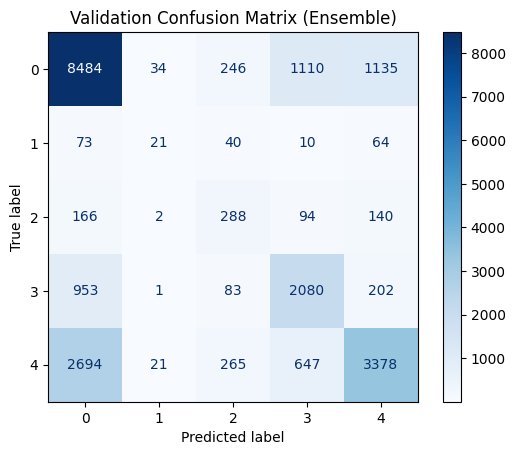

In [ ]:
# Ensemble
val_ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_val),
        ('lgb', lgb_val)
    ],
    voting='soft',
    n_jobs=-1
)
val_ensemble.fit(X_train, y_train)

# Evaluate on validation split
y_val_pred = val_ensemble.predict(X_val)
val_score = balanced_accuracy_score(y_val, y_val_pred)

print(f"📊 Validation Balanced Accuracy: {val_score:.5f}")

disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
disp.plot(cmap='Blues')
plt.title("Validation Confusion Matrix (Ensemble)")
plt.show()

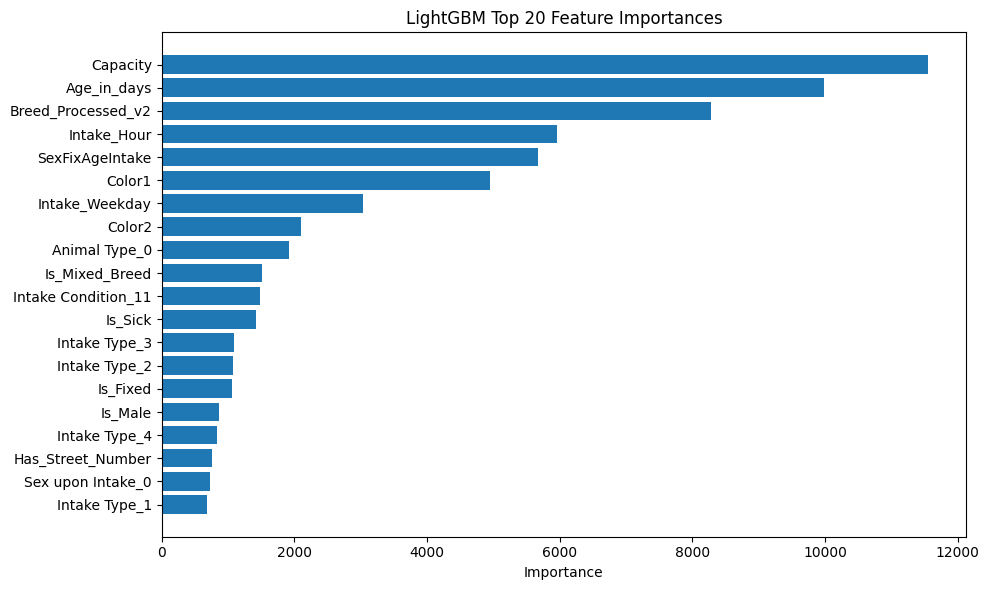

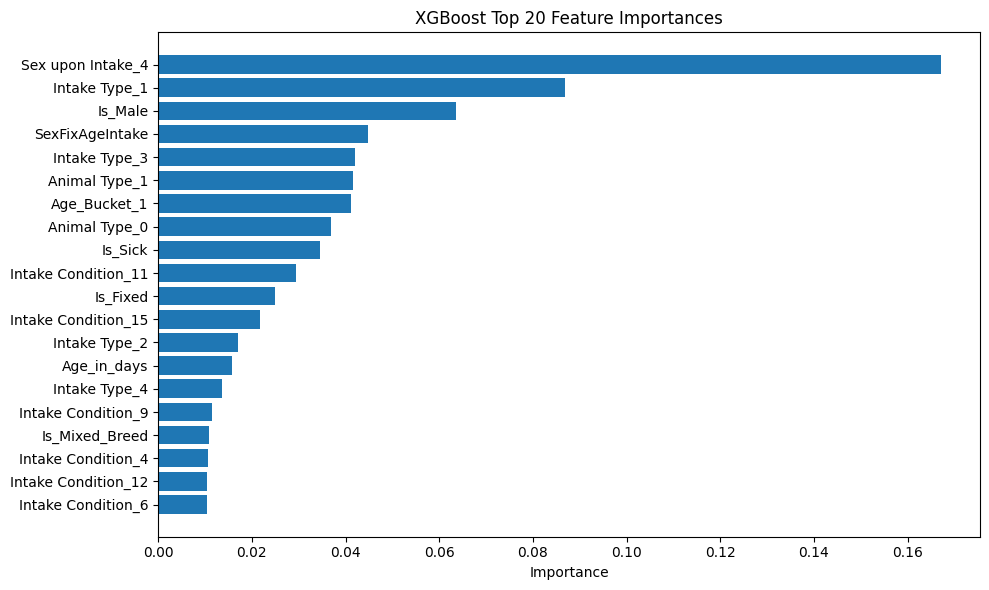

In [ ]:
# === Predict on the real test set ===
def plot_feature_importances(model, feature_names, model_name, top_n=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Importance')
    plt.title(f'{model_name} Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()

# Plot for LightGBM
plot_feature_importances(lgb_val, X_proc.columns, "LightGBM")

# Plot for XGBoost
plot_feature_importances(xgb_val, X_proc.columns, "XGBoost")

In [ ]:
def print_top_features(model, feature_names, model_name, top_n=20):
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1][:top_n]
    print(f"\n🔍 Top {top_n} Features for {model_name}:")
    for i in sorted_idx:
        print(f"{feature_names[i]:<30} Importance: {importances[i]:.4f}")

# LightGBM
print_top_features(lgb_val, X_proc.columns, "LightGBM")

# XGBoost
print_top_features(xgb_val, X_proc.columns, "XGBoost")


🔍 Top 20 Features for LightGBM:
Capacity                       Importance: 11551.0000
Age_in_days                    Importance: 9980.0000
Breed_Processed_v2             Importance: 8278.0000
Intake_Hour                    Importance: 5959.0000
SexFixAgeIntake                Importance: 5670.0000
Color1                         Importance: 4945.0000
Intake_Weekday                 Importance: 3039.0000
Color2                         Importance: 2107.0000
Animal Type_0                  Importance: 1924.0000
Is_Mixed_Breed                 Importance: 1513.0000
Intake Condition_11            Importance: 1488.0000
Is_Sick                        Importance: 1416.0000
Intake Type_3                  Importance: 1084.0000
Intake Type_2                  Importance: 1071.0000
Is_Fixed                       Importance: 1055.0000
Is_Male                        Importance: 868.0000
Intake Type_4                  Importance: 842.0000
Has_Street_Number              Importance: 766.0000
Sex upon Intake

In [ ]:
'''from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confusion_matrix(model, X, y, model_name):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# LightGBM Confusion Matrix
show_confusion_matrix(lgb_val, X_proc, y_encoded, "LightGBM")

# XGBoost Confusion Matrix
show_confusion_matrix(xgb_val, X_proc, y_encoded, "XGBoost")'''

'from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\n\ndef show_confusion_matrix(model, X, y, model_name):\n    y_pred = model.predict(X)\n    cm = confusion_matrix(y, y_pred)\n    disp = ConfusionMatrixDisplay(confusion_matrix=cm)\n    disp.plot(cmap=\'Blues\')\n    plt.title(f\'{model_name} Confusion Matrix\')\n    plt.show()\n\n# LightGBM Confusion Matrix\nshow_confusion_matrix(lgb_val, X_proc, y_encoded, "LightGBM")\n\n# XGBoost Confusion Matrix\nshow_confusion_matrix(xgb_val, X_proc, y_encoded, "XGBoost")'

In [ ]:
'''
# Predict on processed test data
X_test_proc = X_test_proc.reindex(columns=X_proc.columns, fill_value=0)

y_test_preds = boosted_ensemble.predict(X_test_proc)
# Decode label integers back to original strings
y_test_labels = label_encoder.inverse_transform(y_test_preds)

# Build submission DataFrame
submission = pd.DataFrame({
    "ID": test['Id'],  # or whatever your unique ID column is
    "Outcome": y_test_labels
})

# Save to CSV
submission.to_csv("ensemble_submission.csv", index=False)
print("Submission file 'ensemble_submission.csv' saved and ready for upload!")'''

'\n# Predict on processed test data\nX_test_proc = X_test_proc.reindex(columns=X_proc.columns, fill_value=0)\n\ny_test_preds = boosted_ensemble.predict(X_test_proc)\n# Decode label integers back to original strings\ny_test_labels = label_encoder.inverse_transform(y_test_preds)\n\n# Build submission DataFrame\nsubmission = pd.DataFrame({\n    "ID": test[\'Id\'],  # or whatever your unique ID column is\n    "Outcome": y_test_labels\n})\n\n# Save to CSV\nsubmission.to_csv("ensemble_submission.csv", index=False)\nprint("✅ Submission file \'ensemble_submission.csv\' saved and ready for upload!")'

#Final Model Tweaking

ENSEMBLING RF w UPSAMPLE, RF w BASE, LIGHT & XGM

In [ ]:
class PretrainedModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        # No training – model already trained
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

# Tell sklearn this is a classifier
setattr(PretrainedModelWrapper, "_estimator_type", "classifier")


In [ ]:
# another hyperparam ish cell, trying to find best weights for the ensemble
# result was 0.7 LGB, 0.1 rest

from itertools import product
from sklearn.metrics import recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt

# === Split a common validation set from original label-encoded data ===
X_train_common, X_val_common, y_train_common, y_val_common = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === Retrain RF models ===
# --- Base RF ---
rf_model_base.fit(X_train_common, y_train_common)

# --- Upsampled RF ---
df_train = X_train_common.copy()
df_train['Outcome Type'] = y_train_common

n_major = df_train['Outcome Type'].value_counts().max()
resampled_parts = []
for cls in df_train['Outcome Type'].unique():
    group = df_train[df_train['Outcome Type'] == cls]
    group = resample(group, replace=True, n_samples=n_major, random_state=42)
    resampled_parts.append(group)

df_upsampled = pd.concat(resampled_parts)
X_train_up = df_upsampled.drop(columns='Outcome Type')
y_train_up = df_upsampled['Outcome Type']
rf_model.fit(X_train_up, y_train_up)

# === Align boosting model validation set ===
X_val_boosted = X_proc.loc[X_val_common.index].copy()
X_val_boosted = X_val_boosted.reindex(columns=X_proc.columns, fill_value=0)

# === Get prediction probabilities ===
proba_rf_base      = rf_model_base.predict_proba(X_val_common)
proba_rf_upsampled = rf_model.predict_proba(X_val_common)
proba_lgb          = lgb_val.predict_proba(X_val_boosted)
proba_xgb          = xgb_val.predict_proba(X_val_boosted)
'''
# === Custom weighted per-class recall optimization ===
class_weights = np.array([0.10, 0.30, 0.30, 0.10, 0.20])  # by label index

grid = np.arange(0.1, 1.0, 0.1)
best_score = 0
best_weights = None
best_preds = None

for weights in product(grid, repeat=4):
    weights = np.array(weights)
    if not np.isclose(weights.sum(), 1.0):
        continue

    avg_proba = (
        weights[0] * proba_rf_base +
        weights[1] * proba_rf_upsampled +
        weights[2] * proba_lgb +
        weights[3] * proba_xgb
    )

    preds = np.argmax(avg_proba, axis=1)
    recalls = recall_score(y_val_common, preds, average=None, labels=np.arange(5))
    score = np.dot(class_weights, recalls)

    if score > best_score:
        best_score = score
        best_weights = weights
        best_preds = preds

# === Report results ===
print(f"\n🎯 Best Weighted Recall Score: {best_score:.4f}")
print(f"📦 Best Weights:")
print(f"  - RF Base      = {best_weights[0]:.2f}")
print(f"  - RF Upsampled = {best_weights[1]:.2f}")
print(f"  - LightGBM     = {best_weights[2]:.2f}")
print(f"  - XGBoost      = {best_weights[3]:.2f}")

ConfusionMatrixDisplay.from_predictions(y_val_common, best_preds, cmap='Blues')
plt.title("Class-Aware Optimized Ensemble Confusion Matrix")
plt.tight_layout()
plt.show()

print("\n📋 Classification Report:")
print(classification_report(y_val_common, best_preds, target_names=le_target.classes_))
'''

'\n# === Custom weighted per-class recall optimization ===\nclass_weights = np.array([0.10, 0.30, 0.30, 0.10, 0.20])  # by label index\n\ngrid = np.arange(0.1, 1.0, 0.1)\nbest_score = 0\nbest_weights = None\nbest_preds = None\n\nfor weights in product(grid, repeat=4):\n    weights = np.array(weights)\n    if not np.isclose(weights.sum(), 1.0):\n        continue\n\n    avg_proba = (\n        weights[0] * proba_rf_base +\n        weights[1] * proba_rf_upsampled +\n        weights[2] * proba_lgb +\n        weights[3] * proba_xgb\n    )\n\n    preds = np.argmax(avg_proba, axis=1)\n    recalls = recall_score(y_val_common, preds, average=None, labels=np.arange(5))\n    score = np.dot(class_weights, recalls)\n\n    if score > best_score:\n        best_score = score\n        best_weights = weights\n        best_preds = preds\n\n# === Report results ===\nprint(f"\n🎯 Best Weighted Recall Score: {best_score:.4f}")\nprint(f"📦 Best Weights:")\nprint(f"  - RF Base      = {best_weights[0]:.2f}")\npri

Regular ensembling from above shows that LGB doing the best, as the best weights were weighting it at 0.7 and the rest at 0.1, which are the minimums.This made us wonder how we could be smarter about ensembling knowing that LGB was doing the best, but other models were making different mistakes.

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 22231, number of used features: 71
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
📊 Meta-LightGBM Balanced Accuracy: 0.7484

📋 Classification Report:
    

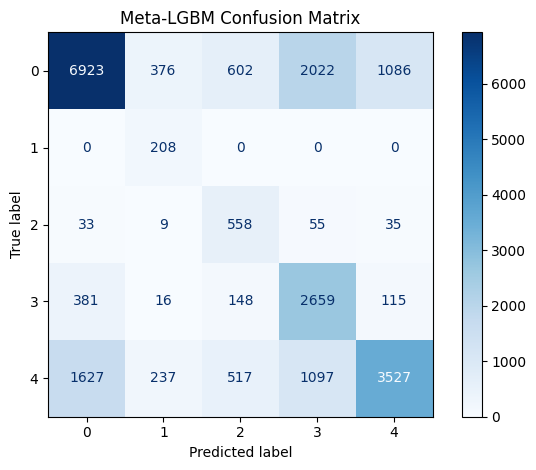

In [ ]:
# === Get predicted probs from each model on the validation set ===
proba_lgb = lgb_val.predict_proba(X_val_boosted)
proba_xgb = xgb_val.predict_proba(X_val_boosted)
proba_rf_base = rf_model_base.predict_proba(X_val_common)
proba_rf_up = rf_model.predict_proba(X_val_common)

# === Build meta features from each model ===
def extract_model_features(proba, model_name):
    preds = np.argmax(proba, axis=1)
    max_confs = proba[np.arange(len(proba)), preds]
    return pd.DataFrame({
        f'{model_name}_pred': preds,
        f'{model_name}_conf': max_confs
    })

meta_features = pd.concat([
    extract_model_features(proba_xgb, 'xgb'),
    extract_model_features(proba_rf_base, 'rf_base'),
    extract_model_features(proba_rf_up, 'rf_up'),
], axis=1)

# Agreement with LGB predictions
lgb_preds = np.argmax(proba_lgb, axis=1)
meta_features['xgb_agrees'] = (meta_features['xgb_pred'] == lgb_preds).astype(int)
meta_features['rf_base_agrees'] = (meta_features['rf_base_pred'] == lgb_preds).astype(int)
meta_features['rf_up_agrees'] = (meta_features['rf_up_pred'] == lgb_preds).astype(int)

# One-hot encode predicted classes
meta_features = pd.get_dummies(meta_features, columns=[
    'xgb_pred', 'rf_base_pred', 'rf_up_pred'
])

# === Combine with original LGB features ===
X_meta = pd.concat([X_val_boosted.reset_index(drop=True), meta_features.reset_index(drop=True)], axis=1)

# === Train new LightGBM model on stacked features ===
lgb_meta = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    subsample=1.0,
    reg_lambda=3,
    reg_alpha=0.5,
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    colsample_bytree=0.7,
    n_jobs=-1
)
lgb_meta.fit(X_meta, y_val_common)

# === Evaluate ===
y_meta_pred = lgb_meta.predict(X_meta)
print(f"📊 Meta-LightGBM Balanced Accuracy: {balanced_accuracy_score(y_val_common, y_meta_pred):.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_val_common, y_meta_pred, target_names=le_target.classes_))

ConfusionMatrixDisplay.from_predictions(y_val_common, y_meta_pred, cmap='Blues')
plt.title("Meta-LGBM Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# Get real feature names and importances
feature_names = X_meta.columns
importances = lgb_meta.feature_importances_

# Build readable table
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display top 30 with names
feat_df.head(30)

,Feature,Importance
23,Capacity,8809
60,xgb_conf,8270
62,rf_up_conf,8050
61,rf_base_conf,7157
7,Age_in_days,6031
0,Breed_Processed_v2,4987
8,Intake_Hour,4067
1,Color1,4046
20,SexFixAgeIntake,2557
9,Intake_Weekday,2530


In [ ]:
# FINAL SUBMISSION BLOCK
# This model combines RF + XGB + LGBM via a meta-LightGBM, which did the best

# === Prepare model predictions on test set ===
# Make sure X_test_proc is the test set processed with preprocess_features()
X_test_proc = X_test_proc.reindex(columns=X_proc.columns, fill_value=0)

proba_lgb_test = lgb_val.predict_proba(X_test_proc)
proba_xgb_test = xgb_val.predict_proba(X_test_proc)
proba_rf_base_test = rf_model_base.predict_proba(X_test)
proba_rf_up_test = rf_model.predict_proba(X_test)

# === Create model-derived meta features ===
def extract_model_features_test(proba, model_name):
    preds = np.argmax(proba, axis=1)
    max_confs = proba[np.arange(len(proba)), preds]
    return pd.DataFrame({
        f'{model_name}_pred': preds,
        f'{model_name}_conf': max_confs
    })

meta_test = pd.concat([
    extract_model_features_test(proba_xgb_test, 'xgb'),
    extract_model_features_test(proba_rf_base_test, 'rf_base'),
    extract_model_features_test(proba_rf_up_test, 'rf_up'),
], axis=1)

# Agreement with base LightGBM
lgb_preds_test = np.argmax(proba_lgb_test, axis=1)
meta_test['xgb_agrees'] = (meta_test['xgb_pred'] == lgb_preds_test).astype(int)
meta_test['rf_base_agrees'] = (meta_test['rf_base_pred'] == lgb_preds_test).astype(int)
meta_test['rf_up_agrees'] = (meta_test['rf_up_pred'] == lgb_preds_test).astype(int)

# One-hot encode the prediction columns
meta_test = pd.get_dummies(meta_test, columns=['xgb_pred', 'rf_base_pred', 'rf_up_pred'])

# Ensure column alignment with training data
meta_test = meta_test.reindex(columns=meta_features.columns, fill_value=0)

# === Combine with original LGB features ===
X_test_meta = pd.concat([X_test_proc.reset_index(drop=True), meta_test.reset_index(drop=True)], axis=1)

# === Predict with the meta model ===
final_preds = lgb_meta.predict(X_test_meta)
final_labels = le_target.inverse_transform(final_preds)

# === Save submission file ===
submission = pd.DataFrame({
    "Id": test_copy['Id'],
    "Outcome": final_labels
})
submission.to_csv("submission_meta_lightgbm.csv", index=False)
print("✅ Submission saved as 'submission_meta_lightgbm.csv'")


✅ Submission saved as 'submission_meta_lightgbm.csv'


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1501
[LightGBM] [Info] Number of data points in the train set: 22231, number of used features: 77
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
📊 Boosted Meta-LightGBM Balanced Accuracy: 0.7493

📋 Classification Report:
                 precision    recall  f1-score   support

       Adoption       0.77      0.63      0.69     11009
           Died       0.24     

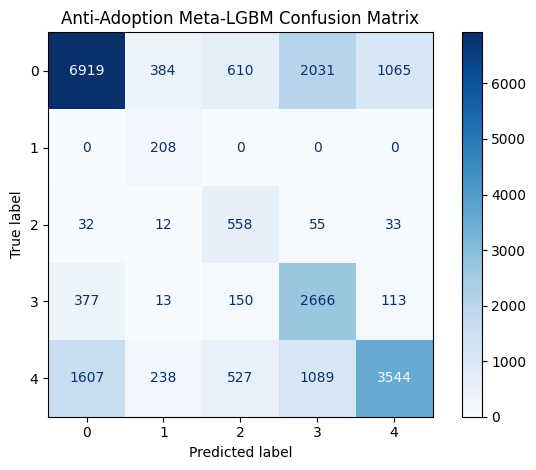

In [ ]:
# === Add anti-Adoption and rare class flags ===
meta_features_boost = meta_features.copy()

# LGB predictions (from proba_lgb / lgb_preds already defined above)
meta_features_boost['lgb_pred'] = lgb_preds
lgb_adoption_conf = proba_lgb[np.arange(len(lgb_preds)), 0]  # confidence for class 0 = Adoption
meta_features_boost['lgb_adoption_uncertain'] = ((lgb_preds == 0) & (lgb_adoption_conf < 0.6)).astype(int)

# Rare class risk flags from other models
meta_features_boost['rare_risk_from_xgb'] = ((meta_features_boost['xgb_conf'] > 0.6) & meta_features_boost.get('xgb_pred_1', 0) | meta_features_boost.get('xgb_pred_2', 0)).astype(int)
meta_features_boost['rare_risk_from_rf_base'] = ((meta_features_boost['rf_base_conf'] > 0.6) & meta_features_boost.get('rf_base_pred_1', 0) | meta_features_boost.get('rf_base_pred_2', 0)).astype(int)
meta_features_boost['rare_risk_from_rf_up'] = ((meta_features_boost['rf_up_conf'] > 0.6) & meta_features_boost.get('rf_up_pred_1', 0) | meta_features_boost.get('rf_up_pred_2', 0)).astype(int)

# All models say adoption
meta_features_boost['all_say_adoption'] = (
    (lgb_preds == 0) &
    meta_features_boost.get('xgb_pred_0', 0) &
    meta_features_boost.get('rf_base_pred_0', 0) &
    meta_features_boost.get('rf_up_pred_0', 0)
).astype(int)

# === Rebuild meta training set ===
X_meta_boost = pd.concat([X_val_boosted.reset_index(drop=True), meta_features_boost.reset_index(drop=True)], axis=1)

# === Retrain LightGBM with boosted features ===
lgb_meta_boosted = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    subsample=1.0,
    reg_lambda=3,
    reg_alpha=0.5,
    n_estimators=500,
    max_depth=10,
    learning_rate=0.01,
    colsample_bytree=0.7,
    n_jobs=-1
)
lgb_meta_boosted.fit(X_meta_boost, y_val_common)

# === Evaluate boosted model ===
y_boosted_pred = lgb_meta_boosted.predict(X_meta_boost)

print(f"📊 Boosted Meta-LightGBM Balanced Accuracy: {balanced_accuracy_score(y_val_common, y_boosted_pred):.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_val_common, y_boosted_pred, target_names=le_target.classes_))

ConfusionMatrixDisplay.from_predictions(y_val_common, y_boosted_pred, cmap='Blues')
plt.title("Anti-Adoption Meta-LGBM Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# binary classifier for adoption vs transfer
# === Filter for Adoption (0) and Transfer (4) ===
binary_mask = np.isin(y_val_common, [0, 4])
X_binary = X_meta[binary_mask]
y_binary = y_val_common[binary_mask]

# === Convert to binary (0 = Adoption, 1 = Transfer) ===
y_binary_bin = (y_binary == 4).astype(int)

# === Split off a true holdout validation set ===
X_train_bin, X_holdout_bin, y_train_bin, y_holdout_bin = train_test_split(
    X_binary, y_binary_bin, test_size=0.25, stratify=y_binary_bin, random_state=42
)

# === Train LGBM binary classifier ===
binary_lgb = LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    reg_alpha=0.3,
    reg_lambda=1.0,
    n_jobs=-1
)
binary_lgb.fit(X_train_bin, y_train_bin)

# === Evaluate on holdout set ===
y_pred_bin = binary_lgb.predict(X_holdout_bin)
score_bin = balanced_accuracy_score(y_holdout_bin, y_pred_bin)

print(f"📊 LGBM Binary Classifier Balanced Accuracy: {score_bin:.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_holdout_bin, y_pred_bin, target_names=["Adoption", "Transfer"]))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5254, number of negative: 8256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1460
[LightGBM] [Info] Number of data points in the train set: 13510, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
# === Get predictions and confidences from meta model ===
proba_meta = lgb_meta.predict_proba(X_meta)
y_meta_pred = np.argmax(proba_meta, axis=1)
conf_meta = proba_meta[np.arange(len(y_meta_pred)), y_meta_pred]

# === Try multiple override thresholds ===
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

for thresh in thresholds:
    override_mask = (
        (y_meta_pred == 0) | (y_meta_pred == 4)
    ) & (conf_meta < thresh)

    if override_mask.sum() == 0:
        print(f"\nThreshold: {thresh}")
        print("No samples to override at this threshold.")
        continue

    X_override = X_meta[override_mask]
    y_override_binary = binary_lgb.predict(X_override)
    y_override_final = np.where(y_override_binary == 0, 0, 4)

    y_meta_final = y_meta_pred.copy()
    y_meta_final[override_mask] = y_override_final

    bal_acc = balanced_accuracy_score(y_val_common, y_meta_final)
    override_count = override_mask.sum()

    print(f"\nThreshold: {thresh}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Overrides Made: {override_count}")
    print("Adoption/Transfer Only Report:")
    print(classification_report(
        y_val_common[(y_val_common == 0) | (y_val_common == 4)],
        y_meta_final[(y_val_common == 0) | (y_val_common == 4)],
        labels=[0, 4],
        target_names=["Adoption", "Transfer"]
    ))



Threshold: 0.2
No samples to override at this threshold.

Threshold: 0.3
Balanced Accuracy: 0.7489
Overrides Made: 107
Adoption/Transfer Only Report:
              precision    recall  f1-score   support

    Adoption       0.81      0.63      0.71     11009
    Transfer       0.77      0.51      0.61      7005

   micro avg       0.80      0.58      0.67     18014
   macro avg       0.79      0.57      0.66     18014
weighted avg       0.79      0.58      0.67     18014


Threshold: 0.4
Balanced Accuracy: 0.7507
Overrides Made: 1904
Adoption/Transfer Only Report:
              precision    recall  f1-score   support

    Adoption       0.82      0.63      0.71     11009
    Transfer       0.77      0.51      0.62      7005

   micro avg       0.80      0.58      0.68     18014
   macro avg       0.79      0.57      0.66     18014
weighted avg       0.80      0.58      0.67     18014


Threshold: 0.5
Balanced Accuracy: 0.7514
Overrides Made: 4793
Adoption/Transfer Only Report:
       

In [ ]:
# === Predict with meta model on test set ===
proba_meta_test = lgb_meta.predict_proba(X_test_meta)
meta_preds_test = np.argmax(proba_meta_test, axis=1)
conf_meta_test = proba_meta_test[np.arange(len(meta_preds_test)), meta_preds_test]

# === Override low-confidence Adoption/Transfer predictions ===
override_mask_test = (
    (meta_preds_test == 0) | (meta_preds_test == 4)
) & (conf_meta_test < 0.3)

X_override_test = X_test_meta[override_mask_test]
binary_override_test = binary_lgb.predict(X_override_test)
binary_override_labels = np.where(binary_override_test == 0, 0, 4)

# === Apply overrides ===
final_preds_override = meta_preds_test.copy()
final_preds_override[override_mask_test] = binary_override_labels
'''
# === Decode and save submission ===
final_labels_override = le_target.inverse_transform(final_preds_override)

submission_final = pd.DataFrame({
    "Id": test_copy["Id"],
    "Outcome": final_labels_override
})
submission_final.to_csv("submission_meta_override_binary.csv", index=False)
print("✅ Final post-pred override submission saved as 'submission_meta_override_binary.csv'")'''

'\n# === Decode and save submission ===\nfinal_labels_override = le_target.inverse_transform(final_preds_override)\n\nsubmission_final = pd.DataFrame({\n    "Id": test_copy["Id"],\n    "Outcome": final_labels_override\n})\nsubmission_final.to_csv("submission_meta_override_binary.csv", index=False)\nprint("✅ Final post-pred override submission saved as \'submission_meta_override_binary.csv\'")'

In [ ]:
# === Add new meta features to test set ===
meta_test_boost = meta_test.copy()

# Confidence for LGB predicting Adoption
lgb_adoption_conf_test = proba_lgb_test[np.arange(len(lgb_preds_test)), 0]
meta_test_boost['lgb_pred'] = lgb_preds_test
meta_test_boost['lgb_adoption_uncertain'] = ((lgb_preds_test == 0) & (lgb_adoption_conf_test < 0.6)).astype(int)

# Rare class risk flags
meta_test_boost['rare_risk_from_xgb'] = ((meta_test_boost['xgb_conf'] > 0.6) & meta_test_boost.get('xgb_pred_1', 0) | meta_test_boost.get('xgb_pred_2', 0)).astype(int)
meta_test_boost['rare_risk_from_rf_base'] = ((meta_test_boost['rf_base_conf'] > 0.6) & meta_test_boost.get('rf_base_pred_1', 0) | meta_test_boost.get('rf_base_pred_2', 0)).astype(int)
meta_test_boost['rare_risk_from_rf_up'] = ((meta_test_boost['rf_up_conf'] > 0.6) & meta_test_boost.get('rf_up_pred_1', 0) | meta_test_boost.get('rf_up_pred_2', 0)).astype(int)

# All say adoption flag
meta_test_boost['all_say_adoption'] = (
    (lgb_preds_test == 0) &
    meta_test_boost.get('xgb_pred_0', 0) &
    meta_test_boost.get('rf_base_pred_0', 0) &
    meta_test_boost.get('rf_up_pred_0', 0)
).astype(int)

# Ensure test features match training
meta_test_boost = meta_test_boost.reindex(columns=meta_features_boost.columns, fill_value=0)

# Combine with LGB test features
X_test_meta_boost = pd.concat([X_test_proc.reset_index(drop=True), meta_test_boost.reset_index(drop=True)], axis=1)

# Predict using boosted meta model
final_preds_boost = lgb_meta_boosted.predict(X_test_meta_boost)
final_labels_boost = le_target.inverse_transform(final_preds_boost)
'''
# Save submission
submission_boost = pd.DataFrame({
    "Id": test_copy["Id"],
    "Outcome": final_labels_boost
})
submission_boost.to_csv("submission_meta_lightgbm_boosted.csv", index=False)
print("✅ Boosted meta-model submission saved as 'submission_meta_lightgbm_boosted.csv'")
'''

'\n# Save submission\nsubmission_boost = pd.DataFrame({\n    "Id": test_copy["Id"],\n    "Outcome": final_labels_boost\n})\nsubmission_boost.to_csv("submission_meta_lightgbm_boosted.csv", index=False)\nprint("✅ Boosted meta-model submission saved as \'submission_meta_lightgbm_boosted.csv\'")\n'

In [ ]:
# Get real feature names and importances
feature_names = X_meta.columns
importances = lgb_meta.feature_importances_

# Build readable table
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display top 30 with names
feat_df.head(30)


,Feature,Importance
23,Capacity,8809
60,xgb_conf,8270
62,rf_up_conf,8050
61,rf_base_conf,7157
7,Age_in_days,6031
0,Breed_Processed_v2,4987
8,Intake_Hour,4067
1,Color1,4046
20,SexFixAgeIntake,2557
9,Intake_Weekday,2530
